# COVID-19 ABM Simulations

### Chirag Kumar - 20.09.2020

### This script develops and tests interventions for COVID-19 spread simulated using an ABM.

## Prep Workspace

### Import and Set-up Packages: Python and R

In [1]:
# python packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for matplotlib settings
import os # for directories
#import rpy2 # for running r commands - namely plotting
from scipy.optimize import minimize # for optimization of noisy functions
from sodapy import Socrata # for quering CDC data
#from ddf_utils.factory.ihme import IHMELoader # for quering GHDx data
import scipy as sp # useful to have the whole library to access
from scipy import stats # for statistics and distributions
from scipy import integrate # for numerical integration processes
from scipy import signal # for finding peaks in data
from scipy import optimize # for optimizing functions
from sklearn.linear_model import LinearRegression # for easy linear regression
#import statsmodels.formula.api as smf # for GLMs
import statsmodels.api as sm
from tqdm.auto import tqdm # for progress bars
from tqdm.contrib.concurrent import process_map # for multiprocessing with progress bars
import pickle # for serializing objects
import datetime # for time series data
#import pathos # for multiprocessing
#import multiprocess # for multiprocessing
#import multiprocessing
#import numba # for fast compiling
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid, MultiGrid
from mesa.datacollection import DataCollector
#from mesa.visualization.modules import CanvasGrid
#from mesa.visualization.ModularVisualization import ModularServer
#from mesa.batchrunner import BatchRunner
#from mesa.batchrunner import BatchRunnerMP

In [2]:
# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

### Define Directories

In [3]:
# define directories

# this is a hack to be able to refer to relative locations
if '__file__' not in globals():
    __file__ = '.'

inp_dir = os.path.abspath(os.path.dirname(__file__))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                        'Data'))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                       'Result Files'))
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                          'Figures'))

### Get Data

#### COVID Cases (US) by Age and Gender - CDC

In [4]:
# set up client to get covid related data from cdc website
client_cdc = Socrata("data.cdc.gov",
                     "jvzE0iypgHmNoGyLoXS87pl9q") # this string is my app token

In [5]:
covid_cases_ag = pd.DataFrame.from_records(client_cdc.get("vbim-akqf", limit = 100000000))

In [6]:
max_date = pd.to_datetime(covid_cases_ag.cdc_report_dt).max()

In [7]:
covid_cases_ag = covid_cases_ag.drop(['cdc_report_dt', 'current_status', 'death_yn', 'hosp_yn', 'icu_yn',
                                     'medcond_yn', 'onset_dt', 'pos_spec_dt', 'race_ethnicity_combined'], axis = 1)

In [8]:
covid_cases_ag = covid_cases_ag.loc[np.logical_and(np.logical_not(np.logical_or(covid_cases_ag.age_group.str.contains('Unknown',
                                                                                                       regex = False),
                                                                covid_cases_ag.age_group.str.contains('NA',
                                                                                                      regex = False))),
                                                  np.logical_or(covid_cases_ag.sex.str.contains('Female',
                                                                                                regex = False),
                                                                covid_cases_ag.sex.str.contains('Male',
                                                                                               regex = False))), :]

covid_cases_ag['count'] = 1

In [13]:
tt1

cdc_case_earliest_dt    count
age_group     sex                                  
0 - 9 Years   Female                253074   253074
              Male                  266249   266249
10 - 19 Years Female                699401   699401
              Male                  649519   649519
20 - 29 Years Female               1340375  1340375
              Male                 1194474  1194474
30 - 39 Years Female               1120173  1120173
              Male                 1051739  1051739
40 - 49 Years Female               1037541  1037541
              Male                  951722   951722
50 - 59 Years Female                991837   991837
              Male                  931534   931534
60 - 69 Years Female                689609   689609
              Male                  668156   668156
70 - 79 Years Female                389415   389415
              Male                  365073   365073
80+ Years     Female                358225   358225
              Male                  214148   214148

In [12]:
tt1 = covid_cases_ag.groupby(['age_group', 'sex']).count()
tt1 = pd.DataFrame(tt1.values.reshape((9, 2)))

ValueError: cannot reshape array of size 36 into shape (9,2)

In [ ]:
tt1.index = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
             '60 - 69 Years', '70 - 79 Years', '80+ Years']

tt1.columns = ['Female', 'Male']

In [ ]:
covid_cases_age_gender = tt1.copy(deep = True)

In [ ]:
# export the data
covid_cases_age_gender.to_csv(os.path.join(data_dir, 'COVID-Cases_Age-Gender.csv'), index = False)

covid_cases_age_gender = pd.read_csv(os.path.join(data_dir, 'COVID-Cases_Age-Gender.csv'))

In [ ]:
covid_cases_age_gender.index = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
             '60 - 69 Years', '70 - 79 Years', '80+ Years']

In [ ]:
covid_cases_age_gender

#### COVID Deaths (US) by Age and Gender - CDC

In [ ]:
# set up client to get covid related data from cdc website
client_cdc = Socrata("data.cdc.gov",
                     "jvzE0iypgHmNoGyLoXS87pl9q") # this string is my app token

In [ ]:
# get the data from the cdc website
covid_deaths_ag = client_cdc.get("9bhg-hcku", limit = 10000000)

In [ ]:
# turn it into a dataframe
covid_deaths_ag = pd.DataFrame.from_records(covid_deaths_ag)

In [ ]:
covid_deaths_ag

In [ ]:
# annoyingly, there are no standard age groups that all the data uses, so take a look at what age groups are
# used in this data set
covid_deaths_ag.age_group_new.value_counts()

In [ ]:
# filter just the columns we want: sex, age, and number of deaths

covid_deaths_age_gender = covid_deaths_ag.loc[np.logical_and(covid_deaths_ag.state == 'United States',
                                                          np.logical_or(covid_deaths_ag.sex == 'Male',
                                                                        covid_deaths_ag.sex == 'Female')),
                                           ['sex',
                                            'age_group_new',
                                            'covid_19_deaths']].reset_index(drop = True)

In [ ]:
# filter so that we have the age groups with the most resolution

tt1 = np.logical_and(np.logical_and(np.logical_and(np.logical_and(covid_deaths_age_gender.age_group_new != 'All Ages',
                              covid_deaths_age_gender.age_group_new != '0-17 years'),
               covid_deaths_age_gender.age_group_new != '18-29 years'),
               covid_deaths_age_gender.age_group_new != '30-49 years'),
                    covid_deaths_age_gender.age_group_new != '50-64 years')

covid_deaths_age_gender = covid_deaths_age_gender.loc[tt1, :]

In [ ]:
# take a look at the data
covid_deaths_age_gender.head()

In [ ]:
# check that we have the right age groups
covid_deaths_age_gender.age_group_new.value_counts()

In [ ]:
# however, this data is not on the same time scale as the cases data above (cases data lags)
# so take only the proportion of deaths preceeding the `max_date`
covid_deaths_time = pd.DataFrame.from_records(client_cdc.get("r8kw-7aab",
                                                   limit = 10000000))

In [ ]:
covid_deaths_time = covid_deaths_time[covid_deaths_time.state == 'United States']

In [ ]:
tt1 = covid_deaths_time[pd.to_datetime(covid_deaths_time.start_week) < max_date].covid_deaths.astype(np.float64).sum()
tt2 = covid_deaths_time.covid_deaths.astype(np.float64).sum()

In [ ]:
deaths_fraction = tt1 / tt2

In [ ]:
covid_deaths_age_gender.covid_19_deaths = covid_deaths_age_gender.covid_19_deaths.astype(float)

In [ ]:
covid_deaths_age_gender.covid_19_deaths *= deaths_fraction

In [ ]:
# export the data
covid_deaths_age_gender.to_csv(os.path.join(data_dir, 'COVID-Deaths_Age-Gender.csv'), index = False)

In [ ]:
covid_deaths_age_gender = pd.read_csv(os.path.join(data_dir, 'COVID-Deaths_Age-Gender.csv'))

#### COVID Deaths (US) by Comorbidities - CDC

In [ ]:
# this is the same process as with the cases by age and gender data above
covid_deaths_cm = client_cdc.get("hk9y-quqm", limit = 1000000)

In [ ]:
covid_deaths_cm = pd.DataFrame.from_records(covid_deaths_cm)

In [ ]:
covid_deaths_cm.shape

In [ ]:
covid_deaths_cm.head()

In [ ]:
covid_deaths_cm.condition.unique()

In [ ]:
covid_deaths_cm.age_group.value_counts()

In [ ]:
covid_deaths_cm

In [ ]:
covid_deaths_comorbidities = covid_deaths_cm.loc[covid_deaths_cm.state == 'US', :]

In [ ]:
covid_deaths_comorbidities = covid_deaths_comorbidities[['condition_group', 'condition', 'age_group', 'number_of_mentions']]

In [ ]:
covid_deaths_comorbidities = covid_deaths_comorbidities.rename(columns = {'number_of_mentions':'number_covid19_deaths'})

In [ ]:
tt1 = np.logical_and(covid_deaths_comorbidities.age_group != 'All ages',
                     covid_deaths_comorbidities.age_group != 'Not stated')

covid_deaths_comorbidities = covid_deaths_comorbidities.loc[tt1, :]

In [ ]:
covid_deaths_comorbidities.head()

In [ ]:
covid_deaths_comorbidities.age_group.value_counts()

In [ ]:
covid_deaths_comorbidities.condition.value_counts()

In [ ]:
covid_deaths_comorbidities.number_covid19_deaths = covid_deaths_comorbidities.number_covid19_deaths.astype(float)

covid_deaths_comorbidities.number_covid19_deaths *= deaths_fraction

In [ ]:
# export the data
covid_deaths_comorbidities.to_csv(os.path.join(data_dir, 'COVID-Deaths_Comorbidities.csv'), index = False)

In [ ]:
covid_deaths_comorbidities = pd.read_csv(os.path.join(data_dir, 'COVID-Deaths_Comorbidities.csv'))

#### Data on Comorbidities Prevalence (US) - GHBx

In [ ]:
# TO DO IN AN AUTOMATED FASHION...
#client_ihme = IHMELoader()

In [ ]:
#client_ihme.bulk_download(out_dir = data_dir,
#                          version = [i for i in range(1000) if client_ihme.has_newer_source(i)][-1] + 1,
#                         context = ['le'], year = [2017])

In [ ]:
# read the comorbidities data that ruchita gave me...
# these are prevalence values, not incidences
comorbidities_prevalence = pd.read_csv(os.path.join(data_dir,
                                                    'IHME-GBD_2017_DATA-66c072b7-1/IHME-GBD_2017_DATA-66c072b7-1-SpecificAgesOnly.csv'))

In [ ]:
# take just the variable i need
comorbidities_prevalence = comorbidities_prevalence.loc[:, ['sex', 'age', 'cause', 'val']]

In [ ]:
# take a look at the data
comorbidities_prevalence.head()

In [ ]:
# add obesity data from the cdc
#20–39 40–59 60 and over
#
#Men 40.3(3.8) 46.4(3.2) 42.2 (3.3)
#Women 39.7(2.7) 43.3 (2.7) 43.3 (3.0)

tt1 = comorbidities_prevalence.loc[comorbidities_prevalence.cause == 'Chronic respiratory diseases', :]
tt1.loc[:, 'cause'] = 'Obesity'

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '20 to 24',
                                                tt1.age == '25 to 29'),
                                  tt1.age == '30 to 34'),
                   tt1.age == '35 to 39')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .403
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .397

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '40 to 44',
                                                tt1.age == '45 to 49'),
                                  tt1.age == '50 to 54'),
                   tt1.age == '55 to 59')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .464
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .433

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .403
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .397

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '60 to 64',
                                                tt1.age == '65 to 69'),
                                  tt1.age == '70 to 74'),
                   tt1.age == '75 to 79')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .422
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .433

comorbidities_prevalence = pd.concat([comorbidities_prevalence,
                                     tt1], axis = 0)

In [ ]:
# age resolution of the data
comorbidities_prevalence.age.value_counts()

In [ ]:
# what types of comorbidities do we have in the data?
comorbidities_prevalence.cause.value_counts()

#### Testing Effectiveness

In [ ]:
# turn them into a nice dataframe
testing_effectiveness = pd.DataFrame(columns = ['sensitivity',
                                                'specificity'], index = ['rt-pcr',
                                                                         'antibody',
                                                                        'antigen'])
# recall sensitivity is true positives / (true pos + false negs)
# recall specificity is true negatives / (true negs + false positive)
testing_effectiveness.loc['rt-pcr', 'sensitivity'] = 1 # it's 1 because of the constraints for testing positive discussed below
testing_effectiveness.loc['rt-pcr', 'specificity'] = .99 # https://www.cell.com/med/pdf/S2666-6340(20)30016-7.pdf
# https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmv.26211?casa_token=o2avJ_hHuagAAAAA%3ApBIZmAW7hn4vwT4rO5xWKP2CqjGo34TkkcVQ_EZ1_JtmLG_p_A4KLOlUvcOtekHDSvGUMIbUVTxrKAFO
testing_effectiveness.loc['antibody', 'sensitivity'] = .96
testing_effectiveness.loc['antibody', 'specificity'] = 0.95
# Comparison of automated SARS-CoV-2 antigen test for COVID-19 infection with quantitative RT-PCR using 313 nasopharyngeal
# swabs, including from seven serially followed patients
testing_effectiveness.loc['antigen', 'sensitivity'] = [1, 0.6, 0.33, 0.26] # sensitivity for >2, 1-2, 0-1, <0 viral loads
testing_effectiveness.loc['antigen', 'specificity'] = 1

In [ ]:
testing_effectiveness

#### Probability of Transmission Over Time

In [ ]:
bootstrapped_gamma_params = pd.read_csv(os.path.join(data_dir,
                                                     'InfectiousnessGamaDistributionBootstrappedParameters.csv'))
bootstrapped_gamma_params = bootstrapped_gamma_params.drop('Unnamed: 0', axis = 1)

In [ ]:
bootstrapped_gamma_params.head()

#### Viral Load Over Time

In [ ]:
# units of log10 copies per mL
viral_load = pd.read_csv(os.path.join(data_dir,
                                      'ViralLoadDaysSinceSymptomOnsetMetaAnalysis-SpatialTemporalDynamics.csv'))
viral_load = viral_load.loc[np.logical_and(viral_load.Swab == 'URT',
                                          True), :]
viral_load = viral_load.drop(['Author'], axis = 1)

In [ ]:
viral_load.head()

In [ ]:
#tt1 = viral_load.copy(deep = True)

In [ ]:
#tt1['infectiousness'] = [stats.gamma.pdf(x, 20.51651, -12.27248, 1/1.592124) for x in tt1.Day]

In [ ]:
#tt1['infectiousness']

In [ ]:
#plt.scatter(tt1['infectiousness'], tt1['Viral_load_log10'])

In [ ]:
#plt.scatter(viral_load['Day'][viral_load['Day'] > 3], viral_load['Viral_load_log10'][viral_load['Day'] > 3])
#plt.grid()

In [ ]:
viral_load_kinetics = sm.OLS(viral_load['Viral_load_log10'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3],
        np.vstack((np.ones(viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values.shape),
                       viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values)).T).fit()

In [ ]:
viral_load_ct = LinearRegression().fit(np.array([0.91, 10.42]).reshape(-1, 1),
                                       np.array([37.92, 6.16]).reshape(-1, 1))

In [ ]:
ct_viral_load = LinearRegression().fit(np.array([37.92, 6.16]).reshape(-1, 1),
                                       np.array([0.91, 10.42]).reshape(-1, 1))

#### Contacts Distribution

In [ ]:
# number of contacts
k = 0.16 # Estimating the overdispersion in COVID-19 transmissionusing outbreak sizes outside China
m = 2.5
Xs = np.array(range(101))

p_contacts = (sp.special.gamma(k + Xs) / (sp.special.gamma(Xs + 1) * sp.special.gamma(k))) * (np.power(m / (m + k),
                                                                                                       Xs)) * ((1 + (m / k)) ** (-k))
#p_contacts = p_contacts[1:]

#### Duration and Length of Hospital Stay

In [ ]:
# computed negative binomial parameters
duration_nbinom_parameters = pd.read_csv(os.path.join(data_dir, 'NegativeBinomialDistributionParameters.csv'))

In [ ]:
duration_nbinom_parameters.index = ['critical_duration<=49',
                                   'death_hospital<=49',
                                   'critical_duration<=64',
                                   'death_hospital<=64',
                                   'critical_duration>64',
                                   'death_hospital>64',
                                   'duration_overall',
                                   'hospital<=49',
                                   'icu<=49',
                                   'hospital<=64',
                                   'icu<=64',
                                   'hospital>64',
                                   'icu>64']

In [ ]:
duration_nbinom_parameters

### Contact Matrix

In [ ]:
contact = pd.read_csv(os.path.join(data_dir, 'United_States_country_level_M_overall_contact_matrix_85.csv'),
                      header = None)

In [ ]:
contact.index = [*[str(i) for i in range(84)], '84+']

In [ ]:
contact.columns = [*[str(i) for i in range(84)], '84+']

In [ ]:
contact

## Process Data

In [ ]:
# standardize the data from various sources so that it is all interchangeable
# recall that each dataset uses a different set of age groups
# i make dictionaries that map the age groups to specific ages for each dataset

# make a dictionary that links the age groups to ages

age_groups_overall_covid_cases = {'0 - 9 Years' : list(range(0, 10)),
                                  '10 - 19 Years' : list(range(10, 20)),
                                  '20 - 29 Years' : list(range(20, 30)),
                                  '30 - 39 Years' : list(range(30, 40)),
                                  '40 - 49 Years' : list(range(40, 50)),
                                  '50 - 59 Years' : list(range(50, 60)),
                                  '60 - 69 Years' : list(range(60, 70)),
                                  '70 - 79 Years' : list(range(70, 80)),
                                  '80+ Years' : list(range(80, 111))}

age_groups_overall_covid_deaths = {'65-74 years' : list(range(65, 75)),
                                  '85 years and over' : list(range(85, 111)),
                                  '55-64 years' : list(range(55, 65)),
                                  '35-44 years' : list(range(35, 45)),
                                  '75-84 years' : list(range(75, 85)),
                                  '25-34 years' : list(range(25, 35)),
                                  '15-24 years' : list(range(15, 25)),
                                  '1-4 years' : list(range(1, 5)),
                                  'Under 1 year' : list(range(0, 1)),
                                  '5-14 years' : list(range(5, 15)),
                                  '45-54 years' : list(range(45, 55))}


age_groups_comorbidities_covid_deaths = {'65-74' : list(range(65, 75)),
                                  '85+' : list(range(85, 111)),
                                  '55-64' : list(range(55, 65)),
                                  '35-44' : list(range(35, 45)),
                                  '75-84' : list(range(75, 85)),
                                  '25-34' : list(range(25, 35)),
                                  '0-24' : list(range(0, 25)),
                                  '45-54' : list(range(45, 55))}

age_groups_comorbidities = {'1 to 4' : list(range(0, 5)),
                            '5 to 9' : list(range(5, 10)),
                            '10 to 14' : list(range(10, 15)),
                            '15 to 19' : list(range(15, 20)),
                            '20 to 24' : list(range(20, 25)),
                            '25 to 29' : list(range(25, 30)),
                            '30 to 34' : list(range(30, 35)),
                            '35 to 39' : list(range(35, 40)),
                            '40 to 44' : list(range(40, 45)),
                            '45 to 49' : list(range(45, 50)),
                            '50 to 54' : list(range(50, 55)),
                            '55 to 59' : list(range(55, 60)),
                            '60 to 64' : list(range(60, 65)),
                            '65 to 69' : list(range(65, 70)),
                            '70 to 74' : list(range(70, 75)),
                            '75 to 79' : list(range(75, 80)),
                            '80 to 84' : list(range(80, 85)),
                            '85 to 89' : list(range(85, 90)),
                            '90 to 94' : list(range(90, 95)),
                            '95 plus' : list(range(95, 111))}

In [ ]:
# Finally, make an comorbidities dictionary that maps the comorbidities in the covid deaths data to the
# comorbdities for which we have prevalence

### TO BE IMPROVED ONCE WE HAVE MORE DETAILED COMORBIDITIES DATA

comorbidities_aggregate = {'Chronic respiratory diseases' : ['Chronic lower respiratory diseases',
                                                           'Adult respiratory distress syndrome',
                                                           'Respiratory arrest',
                                                           'Other diseases of the respiratory system'],
                          'Cardiovascular diseases' : ['Hypertensive diseases',
                                                     'Ischemic heart disease',
                                                     'Cardiac arrhythmia',
                                                     'Cerebrovascular diseases',
                                                     'Other diseases of the circulatory system'],
                          'Respiratory infections and tuberculosis' : ['Sepsis'],
                          'Diabetes and kidney diseases' : ['Diabetes', 'Renal failure'],
                          'Neoplasms' : ['Malignant neoplasms'],
                           'Obesity' : ['Obesity'],
                           "Alzheimer's disease and other dementias" : ['Alzheimer disease',
                                                                        'Vascular and unspecified dementia'],
                           'Other conditions' : ['All other conditions and causes (residual)',
                                 'Influenza and pneumonia',
                                 'Respiratory failure',
                                 'Respiratory arrest',
                                 'Cardiac arrest',
                                 'Heart failure'],
                          None : ['COVID-19',
                                  'Intentional and unintentional injury, poisoning and other adverse events']}

## Set Population Profile and COVID Testing Scenario

In [ ]:
# set age and gender from us census
age_gender_profile = pd.read_csv(os.path.join(data_dir, 'USCensus.csv'))

In [ ]:
age_gender_profile

In [ ]:
age_gender_profile = age_gender_profile[1:]

In [ ]:
age_gender_profile['Male'] = age_gender_profile['Male'].str.replace(',', '').astype(float)

In [ ]:
age_gender_profile['Female'] = age_gender_profile['Female'].str.replace(',', '').astype(float)

In [ ]:
class cost(object):    
    def __init__(self):
        self.running_total = 0.0
        
    # https://www.wsj.com/articles/covid-19-tests-answers-on-cost-accuracy-and-turnaround-time-11599134378
    def rt_pcr(self):
        self.running_total += 180.0
        
    def antigen(self):
        self.running_total += 5.0 # also kinda an estimate
        
    def quarantine(self):
        self.running_total += 0.0
        
    def antibody(self):
        self.running_total += 5.0 # really an estimate
        
    def icu(self):
        self.running_total += 0.0
        
    def hospital(self):
        self.running_total += 0.0
        
    def death(self):
        self.running_total += 0.0

In [ ]:
class mitigation():
    """Various testing/quarantining/etc scenarios"""
    def __init__(self, testing_effectiveness, groups, period):
        self.groups = groups
        self.period = period
        self.testing_effectiveness = testing_effectiveness
        self.chunks = list(range(self.groups))
        self.testing = False
        self.current_chunk = self.chunks[0]
        self.cost = cost()
        
    # baseline scenario - no safety measures at all
    # trump strategy
    def baseline(self, agent, i):
        return None
    
    # randomly test people - small college strategy
    def rt_pcr_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk: # test this group of agents
            self.cost.rt_pcr()
            if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
                # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
                if current_viral_load > 0.91:
                    return True
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
        
    # test those who are symptomatic only
    def rt_pcr_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.rt_pcr()
            
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
            
            if current_viral_load > 0.91 and np.random.uniform(low = 0.0, high = 1.0,
                                             size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'sensitivity']:
                return True
            if current_viral_load <= 0.91 and np.random.uniform(low = 0.0,
                                                                high = 1.0,
                                                                size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'specificity']:
                return True
            else:
                return False
            
    def rt_pcr(self, agent):
        self.cost.rt_pcr()
        if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
            if current_viral_load > 0.91:
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
            return True
        else:
            return False
            
    def antigen_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk: # test this group of agents
            self.cost.antigen()
            if agent.infection_course != None:
                
                sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
                randn = np.random.uniform(low = 0.0, high = 1.0)
                
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                if current_viral_load > 2 and randn < sensitivities[0]:
                    return True
                elif current_viral_load > 1 and randn < sensitivities[1]:
                    return True
                elif current_viral_load > 0 and randn < sensitivities[2]:
                    return True
                elif current_viral_load <= 0 and randn < sensitivities[3]:
                    return True
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
                
    # test those who are symptomatic only
    def antigen_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.antigen()
            
            sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
            randn = np.random.uniform(low = 0.0, high = 1.0)
                
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            if current_viral_load > 2 and randn < sensitivities[0]:
                return True
            elif current_viral_load > 1 and randn < sensitivities[1]:
                return True
            elif current_viral_load > 0 and randn < sensitivities[2]:
                return True
            elif current_viral_load <= 0 and randn < sensitivities[3]:
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
            return True
        else:
            return False
                
    def antibody(self, agent):
        self.cost.antibody()
        if agent.state == 'recovered':
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] >= self.testing_effectiveness.loc['antibody',
                                                                                                  'sensitivity']:
                return False
            else:
                return True
        elif np.random.uniform(low = 0.0, high = 1.0) <= self.testing_effectiveness.loc['antibody',
                                                                                        'specificity']:
            return False
        else:
            return True

In [ ]:
class scenario_details():
    """Holds the details required to specify the COVID transmission scenario explored"""
    
    def __init__(self,
                 comorbidities_distribution, prop_healthy, # population characteristics
                 spreader_prop,
                 cases_age_gender, risk_death_distribution, transmission_probability, # disease characteristics
                 mitigation_strategy, # testing scenario
                 external_connectivity, steps_per_day): # model parameters
        
        # define all the variables in this class as properties for easy access
        self.comorbidities_distribution = comorbidities_distribution # prob of each comorbidity by age,sex
        self.prop_healthy = prop_healthy
        self.spreader_prop = spreader_prop
        self.cases_age_gender = cases_age_gender # cases by age and gender
        self.risk_death_distribution = risk_death_distribution # risk of death for each age, sex, and comorbidity
        self.mitigation_strategy = mitigation_strategy # the testing scenario implemented in the current scenario
        self.external_connectivity = external_connectivity # prob that agents may get covid externally
        self.steps_per_day = steps_per_day # the chunks into which time is discretized
        
        # risk of death distribution is a tuple so break it up into its parts
        self.deaths_ag = risk_death_distribution[0]
        self.deaths_co = risk_death_distribution[1]
        
    # draw a random age from the age distribution
    def rnd_age(self):
        return np.random.choice(age_gender_profile.index,
                                p = age_gender_profile.sum(axis = 1) / age_gender_profile.sum(axis = 1).sum(axis = 0))
    
    # draw a random gender from the gender distribution
    def rnd_gender(self, age):
        gender_distribution = age_gender_profile.loc[age, :]
        if np.random.choice([0, 1], p = gender_distribution / gender_distribution.sum()) == 0:
            return 'Male'
        else:
            return 'Female'
    
    # based on age and gender, give the agent comorbidities
    def rnd_comorbidities(self, age, gender):
        # get risk of comorbidities based on age, gender
        # go from age number to an age range name in the comorbidities data
        age_range_name = [k for k, v in age_groups_comorbidities.items() if int(age) in v][0]
        
        # first let's give the people that are normal no comorbidities
        # data from Prevalence of Optimal Metabolic Health in American Adults:
        # National Health and Nutrition Examination Survey 2009–2016
        randn = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
        if age in range(40): # assume that people from age 0 to 20 have some metabolic health as age in 20-39
            if randn < 0.26 + self.prop_healthy[0]:
                return [None]
        elif age in range(40, 60):
            if randn < 0.105 + self.prop_healthy[1]:
                return [None]
        elif randn < 0.028 + self.prop_healthy[2]:
            return [None]
        
        # now let us allocate comorbidities to the remaining people - and treat them independently
        
        # take a subset of the comorbdity data for only this agent's gender and age
        tt1 = np.logical_and(self.comorbidities_distribution.sex == gender,
                             self.comorbidities_distribution.age == age_range_name)
        temp = self.comorbidities_distribution.loc[tt1, :].reset_index(drop = True)
        
        comorbidities_agent = []
        
        for comorbidity in temp.cause:
            randn = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
            if randn < temp.loc[temp.cause == comorbidity, 'val'].values[0]:
                comorbidities_agent.append(comorbidity)
                
        return comorbidities_agent if len(comorbidities_agent) != 0 else [np.random.choice(list(comorbidities_aggregate.keys()))]
        
    # based on age, gender, and comorbidities, determine the probability of death
    def risk_death(self, age, gender, comorbidities):
        # find overall chance of death given age and gender
        age_range_ = [k for k, v in age_groups_overall_covid_deaths.items() if int(age) in v][0]
        
        # subset just the part of the data that we are interested in 
        tt1 = np.logical_and(self.deaths_ag.sex == gender,
                             self.deaths_ag.age_group_new == age_range_)
        
        deaths_o = self.deaths_ag.loc[tt1, 'covid_19_deaths'].astype(int).values[0]
        
        # to convert to a probability, divide deaths by number of cases
        age_range_name_cases = [k for k, v in age_groups_overall_covid_cases.items() if int(age) in v][0]
        p_death_o = deaths_o / self.cases_age_gender[gender][age_range_name_cases]
        
        # however, this gives us the death for people of this age and gender - need to add in comorbidities
        # i don't have cases by comorbidities, so find how much specific comorbidities increase the probability
        # of death compared to other comorbidities
        
        age_range_name = [k for k, v in age_groups_comorbidities_covid_deaths.items() if int(age) in v][0]
        
        conditions = list(map(comorbidities_aggregate.get, comorbidities))
        
        tt1 = np.logical_and(self.deaths_co.condition.isin([condition[0] for condition in conditions]),
                             self.deaths_co.age_group == age_range_name)
        
        deaths_c = self.deaths_co.loc[tt1, 'number_covid19_deaths'].astype(int).values[0]
        
        deaths_all_c = self.deaths_co.loc[self.deaths_co.age_group == age_range_name,
                                                      'number_covid19_deaths'].astype(int).sum()
        
        risk_increase = deaths_c * len(self.deaths_co.condition.unique()) / deaths_all_c
        
        return p_death_o * risk_increase
    
    def spreader(self):
        if np.random.uniform(low = 0.0, high = 1.0) < self.spreader_prop:
            return True
        else:
            return False
    
    # create the course of the infection for the agent and store everything in a dictionary
    def infection_course(self, age, gender, comorbidities):
        # the infection course: incubation --> infectious-asy --? infectious-s --> R or D
        
        # first figure out for how long this agent will be in incubation
        # data from Incubation period of COVID-19: a rapid systematic review and meta-analysis of observational research
        # probability of symptom development is a lognormal with mu = 1.63 and sigma = 0.50
        incubation_days = round(stats.lognorm.rvs(s = 0.5, loc = 0, scale = np.exp(1.63), size = 1)[0])
        death = False
        # will this agent die?
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] <= self.risk_death(age,
                                                                                   gender,
                                                                                   comorbidities):
            death = True
            # now determine the duration of infection for this agent
            # for an agent that dies, assume that they go to the hospital first
            # at that point, they are no longer infectious
            # however, they may spend some time in the hospital before transitioning to dead
            
            # set a variable 'duration' for how long the individual is infectious - days until hospitalized
            # also set 'hospitalized_time' for how many days later the agent dies -- assume death in the hospital
            # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
            if age <= 49:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            elif age <= 64:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            else:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('   ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            hospitalized_time = hospitalized_time * (hospitalized_time > 0)
            duration = int(duration)
            hospitalized_time = int(hospitalized_time)
            
        else: # the agent can be asymptomatic wholly, symptomatic, and/or hospitalized with recovery
            
            # duration for this type of infection is relatively straightforward
            duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                    :][0].split(' ')[1][:-1]))
            
            # determine whether agent if wholly asymptomatic
            
            # P(A) = 0.4 according to CDC website
            # want P(A | ~D) = P(~D | A) * P(A) / P(~D) = P(A) / P(~D)
            prob_asymptomatic = (.4 / (1 - self.risk_death(age, gender, comorbidities)))
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < prob_asymptomatic:
                asymptomatic = True
            
            else:
                # this agent is symptomatic so is either midly symptomatic or severly symptomatic (hospitalized)
            
                # P(H | ~A) = P(~A | H) * P(H) / P(~A) = P(H) / P(~A)
                randn1 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                randn2 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                
                if age <= 49:
                    # P(H) = P(D) / .024 which is value from CDC for proportion of cases hospitalized that die
                    # P(~A) = 1 - P(A)
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[0:7].sum()
                    p_H += .5 * covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[8:10].sum()
                    p_H += covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[10:12].sum()
                    p_H += covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[20:].sum()
                    p_H /= covid_cases_age_gender.iloc[0:4, :].sum().sum()
                    p_H /= 0.024
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .238: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                elif age <= 64:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[[12, 13]].sum()
                    p_H += .5 * covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[8:10].sum()
                    p_H /= (covid_cases_age_gender.iloc[5, :].sum() + (.5 * covid_cases_age_gender.iloc[6, :].sum()))
                    p_H /= 0.1
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .353: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                else:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group_new').covid_19_deaths.iloc[[14, 15, 16, 17, 18, 19]].sum()
                    p_H /= (covid_cases_age_gender.iloc[[7, 8], :].sum().sum() + (.5 * covid_cases_age_gender.iloc[6, :].sum()))
                    p_H /= 0.266
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('  ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('  ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .361: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu>64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                    :][0].split(' ')[1][:-1]))
                    
                
            duration = int(duration)
            if 'hospitalized_time' in locals():
                hospitalized_time = int(hospitalized_time)

        # what will be the person's viral load? data taken from temporal viral shedding paper
        # gamma distribution parameters are as follows: loc = -12.27248, shape = 20.51651, rate = 1/1.592124
        # 95% CIs are calculated above
        
        #loc = -12.27248
        #shape = 20.51651
        #rate = 1/1.592124
        
        # so I draw the actual parameter estimates from a normal distribution of the values and CIs
        #loc = stats.norm.rvs(loc = loc, scale = abs(res_high.x[0] - res_low.x[0]) / 4, size = 1)[0]
        #shape = stats.norm.rvs(loc = shape, scale = abs(res_high.x[1] - res_low.x[1]) / 4, size = 1)[0]
        #rate = stats.norm.rvs(loc = rate, scale = abs(res_high.x[2] - res_low.x[2]) / 4, size = 1)[0]
        
        # I just take the bootstrapped parameters
        [shape, rate, loc] = bootstrapped_gamma_params.loc[np.random.randint(bootstrapped_gamma_params.shape[0]), :]
        loc *= -1
        rate = 1/rate
        
        # from ramanan's paper, probability of transmission is 7.2% on average, so the average value of the 
        # distribution must be 7.2%
        # so i take the distribution's value and i multiply it by a constant factor
        
        # determine the value for that scale factor, c
        # the true duration of the infection is the incubation_days + duration
        true_duration = incubation_days + duration
        #avg_value = (1 / true_duration) * integrate.quad(stats.gamma.pdf,
        #                                                 a = -incubation_days,
        #                                                 b = duration,
        #                                                 args = (shape, loc, rate))[0]
        #c = 0.072 / avg_value
        
        c = 1
        
        # now turn all this information into a dictionary which concisely and easily stores the info
        # and explains the course of the infection for this agent
        
        tt1 = list(np.repeat('infected-as', incubation_days))
        tt1.extend(list(np.repeat('infected-s', duration)))
        if 'hospitalized_time' in locals():
            tt1.extend(np.repeat('hospitalized', hospitalized_time))
        tt1.append('dead' if death else 'recovered')
        
        tt2 = [c * integrate.quad(stats.gamma.pdf,
                                  a = x,
                                  b = x + 1,
                                  args = (shape,
                                          loc,
                                          rate))[0] for x in range(-int(incubation_days),
                                                                     int(duration))]
        
        tt2 = [x / sum(tt2) for x in tt2]
        
        if 'hospitalized_time' in locals():
            tt2.extend(np.repeat(0, hospitalized_time))
        
        tt2.append(np.nan)
        
        # adjust transmission probabilities for asymptomatic period/people to be .75 of total infectiousness
        # this vaue is from the same cdc source as above
        #tt2 = [.75 * x if state == 'infected-as' else x for x, state in zip(tt2, tt1)]
        
        # have to do a similar thing for the viral load over time
        
        # first create a viral load trajectory for day after peak
        # choose the viral load peak date
        peak = stats.randint(0, 5).rvs()
        time = 0 if 'hospitalized_time' not in locals() else hospitalized_time
        time += duration
        peak = min(peak, time)
        
        # now choose the maximum viral load
        max_load = np.random.uniform(low = 5, high = 11)
        
        # choose the decay slope
        
        tau = stats.norm.rvs(loc = viral_load_kinetics.summary2().tables[1].loc['x1', 'Coef.'],
                        scale = (viral_load_kinetics.summary2().tables[1].loc['x1', '0.975]'] - viral_load_kinetics.summary2().tables[1].loc['x1', '[0.025']) / 3.29)
        
        # now we must infer the viral load distribution prior to symptom onset
        
        if incubation_days == 0:
            viral_load_begins = 0
        else:
            viral_load_begins = stats.randint(-incubation_days, 0).rvs()
        
        # convert the max viral load to a CT value
        max_CT = viral_load_ct.predict(np.array([max_load]).reshape(-1, 1))
        
        # curve goes from a CT value of 40 on day that viral load begins
        
        if viral_load_begins == peak:
            return self.infection_course(age, gender, comorbidities)
        
        CT_prior = LinearRegression().fit(np.array([viral_load_begins, peak]).reshape(-1, 1),
                                              np.array([40, max_CT[0][0]]).reshape(-1, 1))
        
        # now put these two models together to get a complete viral load assessment for this individual
        
        # viral load from peak to end
        tt3 = [max_load + (tau * (day - peak)) for day in range(int(peak), int(time))]
        
        # viral load from shedding to peak
        
        tt3 = [*ct_viral_load.predict(CT_prior.predict(np.arange(viral_load_begins, peak,
                                                                 1).reshape(-1,
                                                                            1)).reshape(-1,
                                                                                        1)).reshape(1,
                                                                                                    -1)[0].tolist(),
               *tt3]
        
        # viral load before shedding
        
        tt3 = [*np.repeat(-np.inf, incubation_days + viral_load_begins), *tt3]
           
        # now need to infer a viral load for days prior to symptom onset
        # assume that it increases linearly until the max with the constraint that it must be 0 on day of exposure
        # this can be done by shifting the data to have day of exposure be (0, 0)
        # the max happens on day 4 from spatial-temporal dynamics paper
        
        #ee1 = np.array(range(int(incubation_days),
        #                     int(incubation_days) + min(4, len(tt3)))).reshape(-1, 1)
        
        #ee2 = np.array(tt3[:min(4, len(tt3))]).reshape(-1, 1)
        #try:
        #    lr = LinearRegression(fit_intercept = False).fit(ee1, ee2)
        #    tt3 = [*lr.predict(np.array(range(int(incubation_days))).reshape(-1, 1)).reshape(1, -1).tolist()[0],
        #           *tt3]
        #except: # possible exceptions are that the person has no covid duration or no incubation period
        #    tt3 = [*np.repeat(0, incubation_days), *tt3]
            
        tt3.append(np.nan)
            
        infection_course = {'states' : tt1,
                            'prob_transmission' : tt2,
                            'viral_load' : tt3,
                            'days_since_exposure' : 0}
        
        return infection_course
    
    def transmit(self, age_t, gender_t, age_i, gender_i, prob_transmission):
        #age_range_name_t = [k for k, v in age_groups_contacts.items() if int(age_t) in v][0]
        #age_range_name_i = [k for k, v in age_groups_contacts.items() if int(age_i) in v][0]
        
        risk_increase = contact.loc[str(age_t) if age_t <= 83 else '84+',
                                    str(age_i) if age_i <= 83 else '84+'] * contact.shape[0] / contact.loc[str(age_t) if age_t <= 83 else '84+', :].sum()
        
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < (prob_transmission * risk_increase):
            return True
        else:
            return False
        
    # go from recovered to susceptible again because of losing immunity or re-infection...
    def susceptible(self, days_since_recovery):
        if days_since_recovery > 90:
            return True
        elif np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= 0.02:
            return True
        else:
            return False
    
    # can the agent get the infection externally through a connection not modeled in the data?
    def external_infection(self):
        return np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= self.external_connectivity

In [ ]:
mitigation_strategy_b = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_standard = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_b.baseline,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

## ABM Development

In [ ]:
# agent class
class person(Agent):
    """A person that can transmit COVID"""
    
    # initialize the agent and set it's characteristics
    def __init__(self, unique_id, model, state, spreader, days_since_recovery = np.nan):
    # each agent is unique in age/gender/comorbidity which is random from
    # the value for each of these variables in the scenario
        super().__init__(unique_id, model)
        
        self.unique_id = unique_id
        # here we set things like the agent's gender, age, and comorbidities
        self.age = self.model.scenario.rnd_age() # random age from the age distribution given
        self.gender = self.model.scenario.rnd_gender(self.age) # 0 for M, 1 for F
        self.comorbidities = self.model.scenario.rnd_comorbidities(self.age, self.gender) 
        
        # finally we initialize the person's health state and how many days since exposure if infected
        self.state = state
        self.infection_course = None if self.state[0] != 'i' else self.model.scenario.infection_course(self.age,
                                                                                                 self.gender,
                                                                                                 self.comorbidities)
        self.prob_transmission = np.nan
        #self.test_result = test_result
        self.history = [state]
        self.step_num = 0
        
        self.interactions = np.ones((14, self.model.num_agents)) * np.nan
        
        self.days_in_quarantine = np.nan
        
        self.just_positive = False
        
        # 70% of people don't spread the disease at all
                 
        self.num_contacts = np.random.choice(range(0, 101), p = p_contacts / p_contacts.sum())
        
        self.spreader = spreader
        
        if self.num_contacts == 0:
            self.spreader = False
        
        #self.superspreader = self.model.scenario.superspreader()
        
        self.time_delay = np.array([np.nan])
        
        #self.immune = self.model.mitigation_strategy.antibody(self)
        self.immune = False
        
    # move the agent
    def move(self):
        
        # brownian motion is good for now - eventually make this so that similar age/gender people are more
        # likely to cluster
        
        # this is currently a brownian motion set up
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
        # record neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, moore = False, include_center = False,
                                                      radius = 1)
        # move rows in interaction array to fit the new neighbors
        temp = self.interactions[:-1, :]
        self.interactions = np.delete(self.interactions, -1, axis = 0)
        self.interactions = temp
        temp = np.ones((1, self.model.num_agents))
        for idx, neighbor in enumerate(neighbors):
            temp[0, idx] = neighbor.unique_id
            
        self.interactions = np.concatenate((temp, self.interactions), axis = 0)
    
    # spread the disease: meaning the agent can infect others or get infected by others
    def disease_spread(self):
        # the agent can only infect others or be infected if the agent is susceptible or infected
        if self.spreader:
            
            # get people around the agent in progressively larger circles
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            
            n_infect = self.num_contacts * self.prob_transmission
            
            if len(cellmates) > 1:
                if n_infect > sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates]):
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                        neighbor.gender,
                                                                                        neighbor.comorbidities)
                else:
                    while n_infect > 1:
                        tt1 = sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates])
                        for neighbor in cellmates:
                            if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                                if self.model.scenario.transmit(self.age, self.gender,
                                                                neighbor.age, neighbor.gender, 1/tt1):
                                    neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                             neighbor.gender,
                                                                                             neighbor.comorbidities)
                        n_infect += -1
            
                    
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            if self.model.scenario.transmit(self.age, self.gender,
                                                            neighbor.age, neighbor.gender, n_infect):
                        
                                neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                                 neighbor.gender,
                                                                                                 neighbor.comorbidities)
        elif self.state == 'susceptible':
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            for neighbor in cellmates:
                if neighbor.state[0] == 'i' and neighbor.spreader and neighbor.num_contacts > 0:
                    if self.model.scenario.transmit(neighbor.age, neighbor.gender,
                                                    self.age, self.gender,
                                                    neighbor.prob_transmission * neighbor.num_contacts):
                        self.infection_course = self.model.scenario.infection_course(self.age,
                                                                                     self.gender,
                                                                                     self.comorbidities)
                        neighbor.num_contacts = max(0, neighbor.num_contacts - 1)
                        
    
    def test(self, N):
        if self.model.scenario.mitigation_strategy(self, N):
            if 'pcr' in self.model.scenario.mitigation_strategy.__name__:
                if np.isnan(self.time_delay)[0]:
                    self.time_delay = np.array([3])
                else:
                    self.time_delay = np.array([*self.time_delay, 3])
            else:
                self.state = 'positive'
                self.spreader = False
                self.just_positive = True
        #elif self.state[0] == 'i' or self.state == 'hospitalized' or self.state == 'susceptible':
        #    if self.model.mitigation_strategy.rt_pcr(self):
        #        self.time_delay = np.array([3])
        
        if sum(self.time_delay > 0) == len(self.time_delay) and (self.state == 'susceptible' or self.state[0] == 'i' or self.state == 'hospitalized'):
            self.time_delay -= 1
        elif 0 in self.time_delay and self.state[0] == 'i':
            self.state = 'positive'
            self.spreader = False
            self.just_positive = True
        else:
            self.time_delay = np.array([np.nan])
            
    def quarantine(self):
        for agent in self.model.schedule.agents:
            if agent.state == 'positive' and agent.just_positive:
                if agent.unique_id in self.interactions.flatten():
                    self.state = 'quarantine'
                    break
    
    # advance the agent one step forward
    def step(self):
        
        # can only move if the agent is alive
        # at this point, if the agent is infected, let's proceed with the agent's infection course
        if self.infection_course != None:
            day = int(self.infection_course['days_since_exposure'])
            if self.state != 'positive' and self.state != 'quarantine':
                self.state = self.infection_course['states'][day]
            elif self.infection_course['states'][day] == 'recovered' and self.state == 'positive':
                negative_tests = 0
                while negative_tests < 2:
                    if not self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
                        negative_tests += 1
                self.state = 'recovered'
            self.prob_transmission = self.infection_course['prob_transmission'][day]
            self.infection_course['days_since_exposure'] += 1 / self.model.scenario.steps_per_day
                
            if np.isnan(self.prob_transmission): # the agent's infection is over
                if self.state == 'positive':
                    self.state = self.infection_course['states'][day]
                self.infection_course = None
                self.spreader = False
                self.immune = True
            
            self.just_positive = False
            
        # only care abt moving agent if part of community
        #if self.state != 'dead' and self.state != 'hospitalized' and np.isnan(self.days_in_quarantine) and self.state != 'recovered':
        if self.state == 'susceptible' or self.state[0] == 'i':
        
            # however, when susceptible, the agent can pick up an infection from an outside connection
            #if self.state == 'susceptible' and self.model.scenario.external_infection():
            #    self.infection_course = self.model.scenario.infection_course(self.age, self.gender,
            #                                                                self.comorbidities)
            
            # test the agents
            if not self.immune:
                self.test(self.step_num)
            
            # determine if any agents must quarantine
            #self.quarantine()
        
            # move the agent one step
            self.move()
            
            # determine if in the movement the agent infected other agents
            self.disease_spread()
            
        self.step_num += 1
            
        #if self.state != 'dead':
        if self.state != 'recovered':
            self.history.append(self.state)
            
        # check if agent can leave quarantine
        #self.days_in_quarantine += 1
        #if self.days_in_quarantine > 14:
        #    if self.infection_course != None:
        #        self.state = self.infection_course['states'][self.infection_course['days_since_exposure']]
        #        if self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
        #            self.state = 'positive'
        #            self.just_positive = False

In [ ]:
# model class
class covid_transmission_model(Model):
    """A model that simulates the spread of COVID and the effectiveness of various testing scenarios."""
    
    # initialize the model
    def __init__(self, N_t, N_i, N_r, width, height, scenario, mitigation_strategy):
        self.running = True
        
        self.scenario = scenario
        self.mitigation_strategy = mitigation_strategy
        self.num_agents = N_t # number total
        self.grid = MultiGrid(width, height, True) # toroidal grid
        self.schedule = RandomActivation(self) # randomly activate agents
        
        # Create agents
        for i in range(self.num_agents):
            if i < (self.scenario.spreader_prop * N_i):
                a = person(i, self, state = 'infected-as', spreader = True)
            elif i < N_i: # number infected but not spreaders
                a = person(i, self, state = 'infected-as', spreader = True)
            elif i < (N_i + N_r): # number recovered
                a = person(i, self, state = 'recovered', spreader = self.scenario.spreader())
            else:
                a = person(i, self, state = 'susceptible', spreader = self.scenario.spreader())
                
            # add the agent to the scheduler
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # collect data from the model for analysis later
        self.datacollector = DataCollector(model_reporters = {"state" : lambda a: [a.history for a in a.schedule.agents]},
                                           agent_reporters = {"state" : lambda a: a.state})
            
    # routine to run at each step of the model
    def step(self):
        # collect the data
        self.datacollector.collect(self)
        # advance the model one step
        self.schedule.step()

In [ ]:
def ABM_RUN(inputs):
    max_steps = inputs[0]
    N_t = inputs[1]
    N_i = inputs[2]
    N_r = inputs[3]
    width = inputs[4]
    height = inputs[5]
    scenario = inputs[6]
    mitigation_strategy = inputs[7]
    ABM_MODEL = covid_transmission_model(N_t, N_i, N_r, width, height, scenario, mitigation_strategy)
    for i in range(max_steps):
        ABM_MODEL.step()
    return ABM_MODEL.datacollector.get_model_vars_dataframe().tail(1).loc[max_steps - 1,
                                                                          'state'], mitigation_strategy.cost.running_total

In [ ]:
def nestedLists_to_DF(results_list, replicates, N_t):
    # turn the results list into a nice states dataframe
    states = pd.DataFrame(np.nan, columns = ['state'], index = range(replicates))
    
    for i in range(replicates):
        states.loc[[i], 'state'] = pd.Series([results_list[:N_t]], index = [i])
        results_list = results_list[N_t:]
        
    return states

In [ ]:
def MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario, mitigation_strategy,
                            n_cores = 6, chunksize = 1):
    # create a results list into which we dump the results
    results_list = []
    costs = []
    
    # process map is from tqdm and has a default progress bar built in
    r = process_map(ABM_RUN, [[max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario,
                                 mitigation_strategy,
                                 n_cores]] * replicates, max_workers = n_cores, chunksize = chunksize)
    
    for item in r:
        results, cost = item
        results_list.extend(results)
        costs.append(cost)

    return nestedLists_to_DF(results_list, replicates, N_t), costs

In [ ]:
fig, ax = plt.subplots(1, 2)

viral_load = np.empty((250, 300))
viral_load[:] = np.nan
for i in tqdm(range(250)):
    age_temp = scenario_standard.rnd_age()
    gender_temp = scenario_standard.rnd_gender(age_temp)
    comorbidities_temp = scenario_standard.rnd_comorbidities(age_temp, gender_temp)
    ii1 = scenario_standard.infection_course(age_temp, gender_temp, comorbidities_temp)
    vv1 = ii1['viral_load']
    ss1 = ii1['states']
    
    if 'infected-s' in ss1:
        symptom_onset = np.where(np.array(ss1) == 'infected-s')[0][0]
        neg_infs = np.where(np.array(vv1) == -np.inf)[0]
        vv1 = np.array(vv1)
        vv1[neg_infs] = -10
    
        days = range(0, len(vv1) - int(symptom_onset))
        days = [*np.arange(-symptom_onset, 0, 1), *days]
    
        ax[0].plot(days, vv1, c = 'grey', alpha = .1)
        ax[1].plot(days, vv1, c = 'grey', alpha = .1)
        ymax = np.nanmax(vv1)
        xmax = np.where(vv1 == ymax)[0][0]
        ax[1].annotate('.',
                       xy = (xmax - symptom_onset, ymax),
                       xytext = (xmax - symptom_onset, ymax),
                       alpha = 0.2)
    
        viral_load[i, (150 - int(symptom_onset)):(150 + len(vv1) - int(symptom_onset))] = vv1
    

#vv1_m = np.nanmedian(viral_load, axis = 0)
#max_v_m = np.where(vv1_m == np.nanmax(vv1_m))[0][0]
#days_m = range(2, 2 + len(vv1_m) - max_v_m)
#days_m = [*np.arange(-max_v_m, 2, 1), *days_m]

#ax[0].plot(days_m, np.median(viral_load, axis = 0), c = 'k')
ax[0].set_xlabel('Days Since Symptom Onset')
ax[0].set_ylabel('Viral load (log10 virions per mL)')
ax[1].set_xlabel('Days Since Symptom Onset')
ax[1].set_ylabel('Viral load (log10 virions per mL)')
ax[0].set_xlim([-20, 40])
ax[0].set_ylim([-5, 13])
ax[1].set_xlim([-1, 8])
ax[1].set_ylim([4, 13])
plt.subplots_adjust(wspace = 0.3)

## Model Testing

In [237]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [238]:
# initialize the model
# 5000 = 32 x 32
# 1000 = 14 x 15

model = covid_transmission_model(N_t = 1000,
                                 N_i = 10,
                                 N_r = 0,
                                 width = 14,
                                 height = 15,
                                 scenario = scenario_weekly,
                                 mitigation_strategy = mitigation_strategy_r)

In [239]:
# run the model for n steps
for i in tqdm(range(201)):
    model.step()

In [240]:
mitigation_strategy_r.cost.running_total

29264580.0

In [241]:
# get the data collected by the model
agents_states = model.datacollector.get_agent_vars_dataframe().reset_index()

In [242]:
sird_counts = pd.DataFrame(columns = range(200), index = ['s', 'i-as', 'i-s', 'i', 'p', 'q', 'r', 'd'])

In [243]:
for i in range(201):
    sird_counts.loc['s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('susceptible').sum()
    sird_counts.loc['i-as', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum()
    sird_counts.loc['i-s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['i', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum() + agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['p', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('positive').sum()
    sird_counts.loc['h', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('hospitalized').sum()
    sird_counts.loc['q', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('quarantined').sum()
    sird_counts.loc['r', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('recovered').sum()
    sird_counts.loc['d', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('dead').sum()
    
sird_counts /= 10

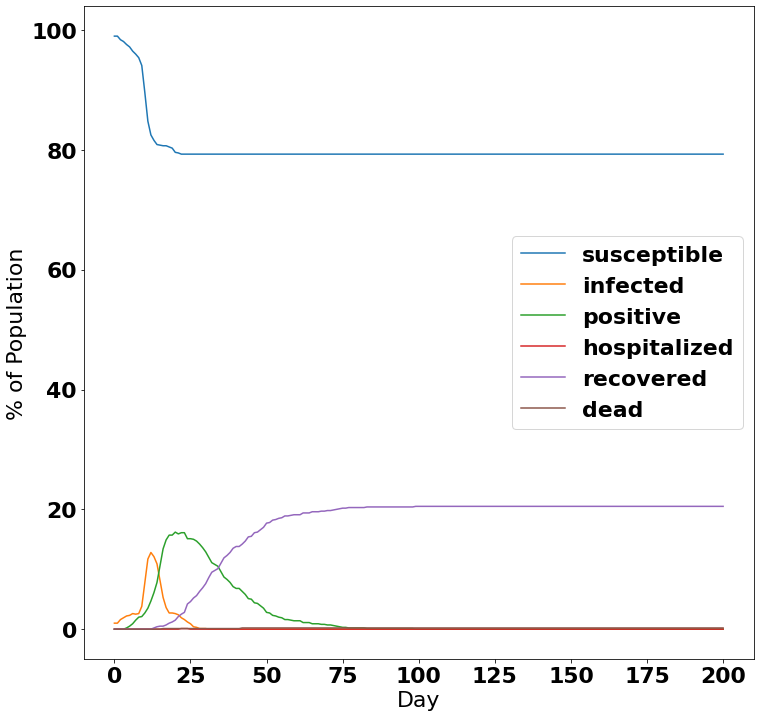

In [245]:
# look at the sird curve (should add "E" at some point)
plt.plot(sird_counts.loc['s', :].T, label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
plt.plot(sird_counts.loc['i', :].T, label = 'infected');
#plt.plot(sird_counts.loc['i-as', :].T, label = 'infected-as');
#plt.plot(sird_counts.loc['i-s', :].T, label = 'infected-s');
plt.plot(sird_counts.loc['p', :].T, label = 'positive');
plt.plot(sird_counts.loc['h', :].T, label = 'hospitalized');
#plt.plot(sird_counts.loc['q', :].T, label = 'quarantined');
plt.plot(sird_counts.loc['r', :].T, label = 'recovered');
plt.plot(sird_counts.loc['d', :].T, label = 'dead');
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');

In [246]:
sird_counts.iloc[:, -1]

s       79.3
i-as     0.0
i-s      0.0
i        0.0
p        0.0
q        0.0
r       20.5
d        0.2
h        0.0
Name: 200, dtype: float64

## No Mitigation

In [96]:
# Current CFR from COVID from CDC data
CFR = covid_deaths_age_gender['covid_19_deaths'].astype(int).sum() / (covid_cases_age_gender.sum().sum() - covid_deaths_age_gender['covid_19_deaths'].astype(int).sum())
print(CFR)
# want percentage of deaths after simulation to equal CFR
# test how accurate that is...

0.030428184284540163


In [103]:
replicates = 200
max_steps = 201

N_t = 5000
#N_t = 1000
N_i = 50
#N_i = 10
N_r = 0
#N_r = 465 # assuming 9.3% seroprevalence from lancet paper

#width = 32
#height = 32

# R0 = 2 = 34 * 35
width = 34
height = 35
#scenario = scenario_standard

n_cores = 40

In [104]:
states, costs = MultiProcessorRunCustom(replicates,
                                 max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario_standard,
                                 mitigation_strategy_b,
                                 n_cores)

In [105]:
sird_counts = np.ones((replicates, 7, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        
#sird_counts[:, 4, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 6, :] + sird_counts[:, 5, :])

sird_counts = sird_counts * 100 / N_t

In [106]:
with open(os.path.join(out_dir, 'NoMitigation/5000Agents-200Replicates-SIRD_counts-R0=2.pickle'), 'wb') as handle:
    pickle.dump(sird_counts, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [6]:
# sird_counts_list = list()
# for i in range(1, 11):
#     with open(os.path.join(out_dir,
#                            'NoMitigation/5000Agents-50Replicates-SIRD_counts-small-' + str(i) + '.pickle'),
#               'rb') as openfile:
#         sird_counts_list.append(pickle.load(openfile))
# sird_counts = np.concatenate(tuple(sird_counts_list))

In [4]:
with open(os.path.join(out_dir,
                           'NoMitigation/5000Agents-200Replicates-SIRD_counts.pickle'),
              'rb') as openfile:
        sird_counts = pickle.load(openfile)

In [19]:
#sird_counts = sird_counts[np.random.randint(low = 0, high = 500, size = 200), :, :]

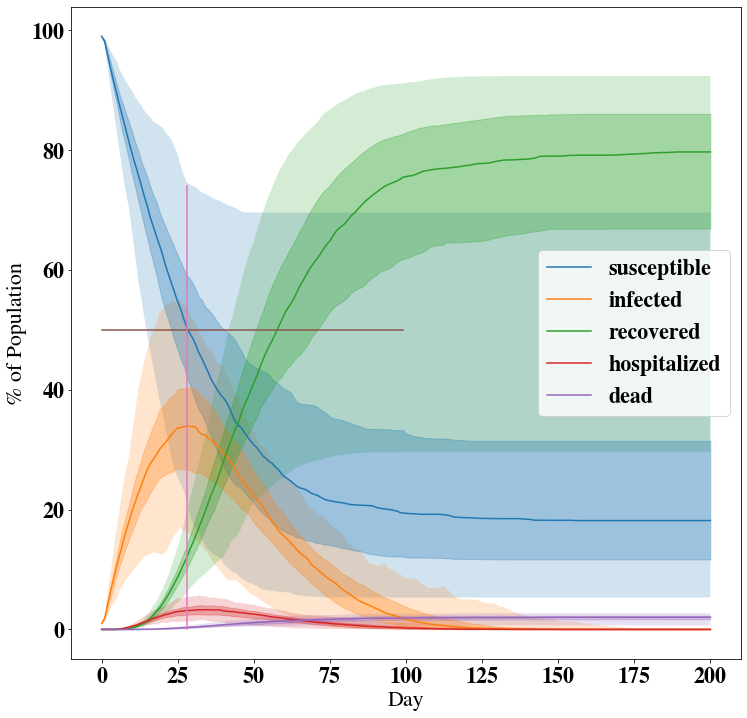

In [107]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
                 np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[3],
                 np.percentile(sird_counts, axis = 0, q = 75)[3], alpha = 0.3, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(3))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))


plt.plot(range(100), np.repeat(100/2, 100))
plt.plot(np.repeat(np.where(np.median(sird_counts, axis = 0)[3] == np.max(np.median(sird_counts, axis = 0)[3]))[0][0],
                   75),
        range(75))

plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-50th&95thPercentiles-5000Agents-200Replicates.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-50th&95thPercentiles-5000Agents-200Replicates.pdf'))

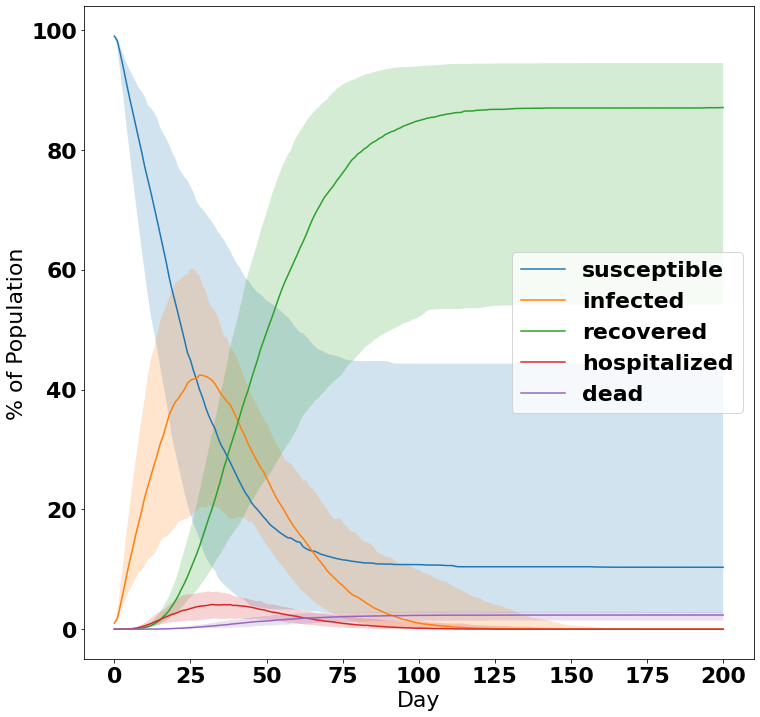

In [169]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)

plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-95thPercentiles-5000Agents-200Replicates.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-95thPercentiles-5000Agents-200Replicates.pdf'))

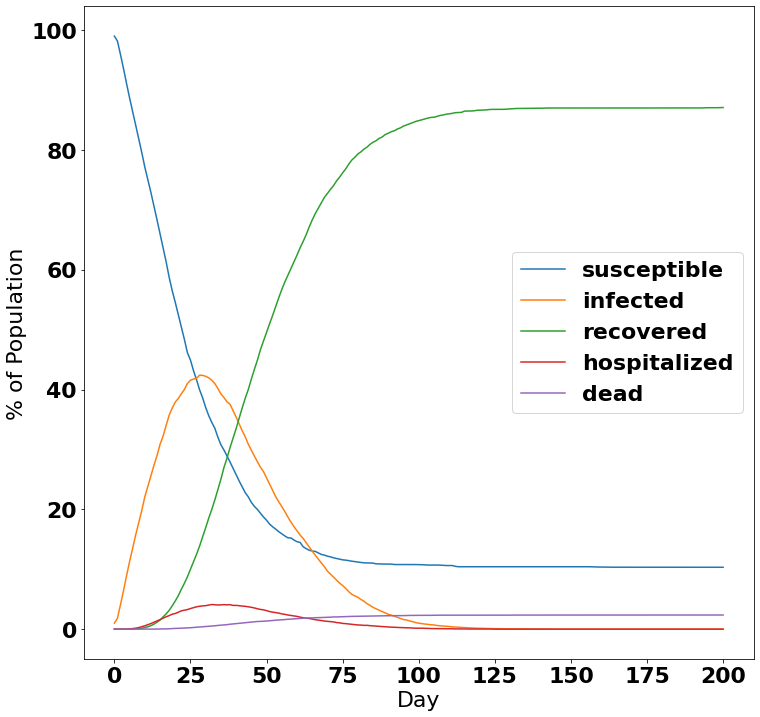

In [170]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
#plt.plot(np.median(sird_counts, axis = 0)[1], label = 'infected-asymptomatic');
#plt.plot(np.median(sird_counts, axis = 0)[2], label = 'infected-symptomatic');
plt.plot(np.median(sird_counts, axis = 0)[3], label = 'infected');
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
#plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-5000Agents-200Replicates-Median.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigationReplicates-5000Agents-200Replicates-Median.pdf'))

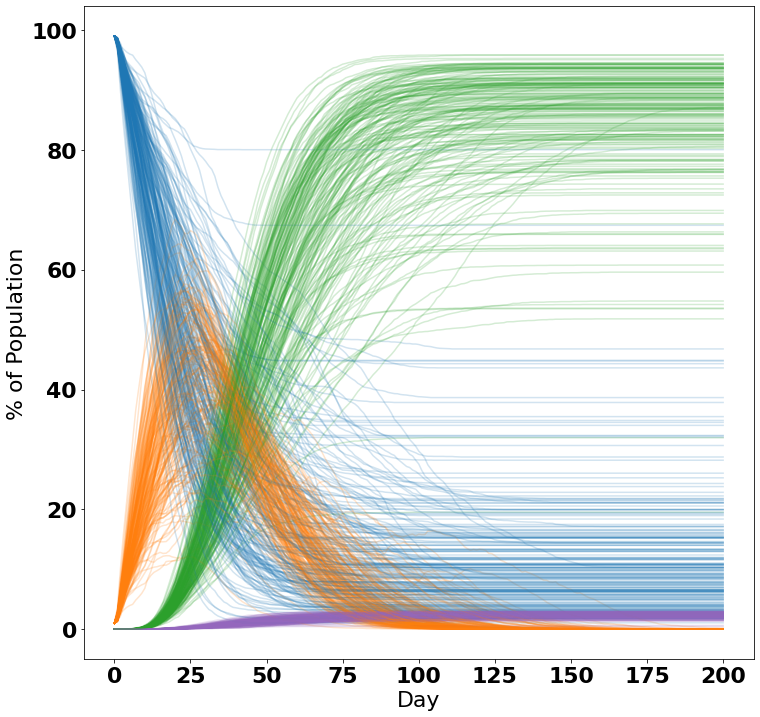

In [171]:
for i in range(replicates):
    plt.plot(sird_counts[i, 0, :].T, c = "C{}".format(0), alpha = .2)
    plt.plot(sird_counts[i, 3, :].T, c = "C{}".format(1), alpha = .2)
    plt.plot(sird_counts[i, 4, :].T, c = "C{}".format(2), alpha = .2)
    plt.plot(sird_counts[i, 6, :].T, c = "C{}".format(4), alpha = .2)

plt.ylabel('% of Population');
plt.xlabel('Day');
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-200Replicates.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-200Replicates.pdf'))

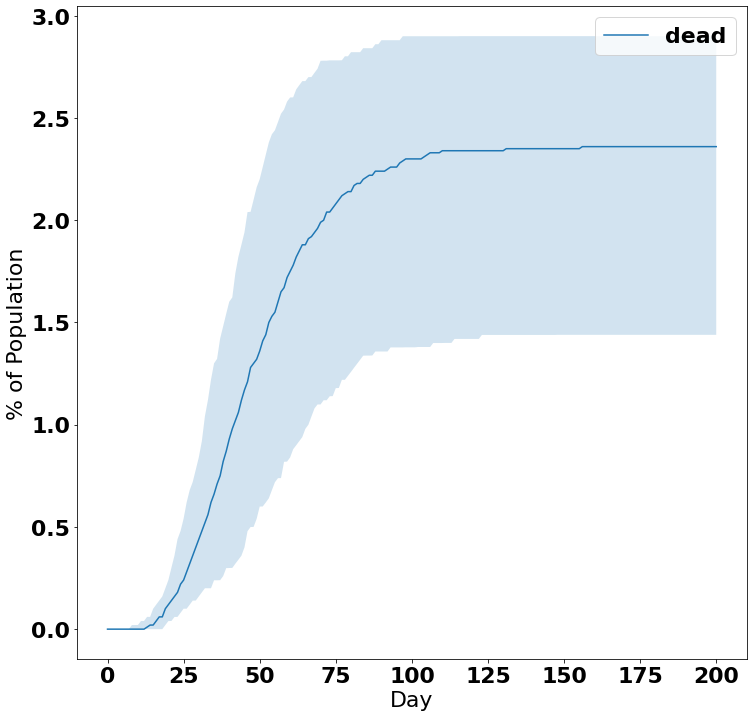

In [172]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

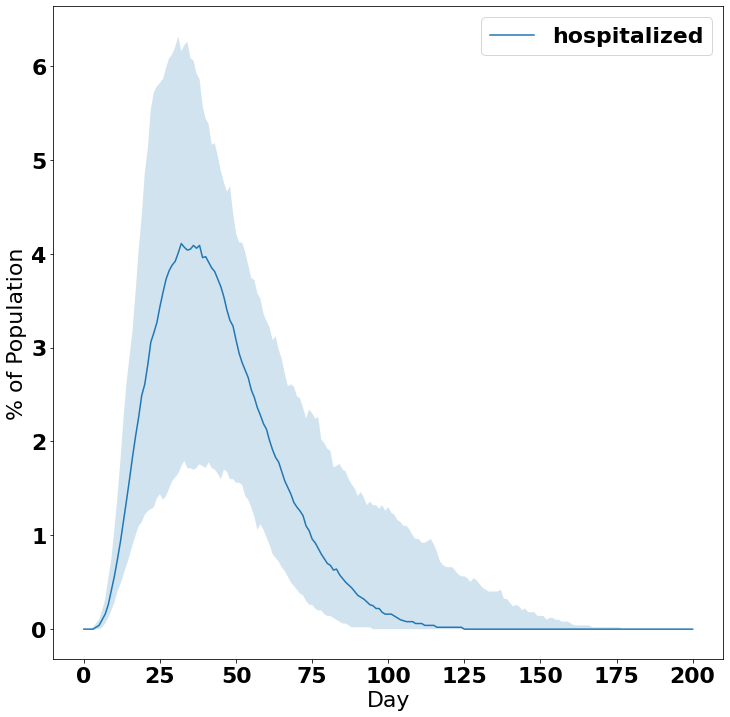

In [173]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

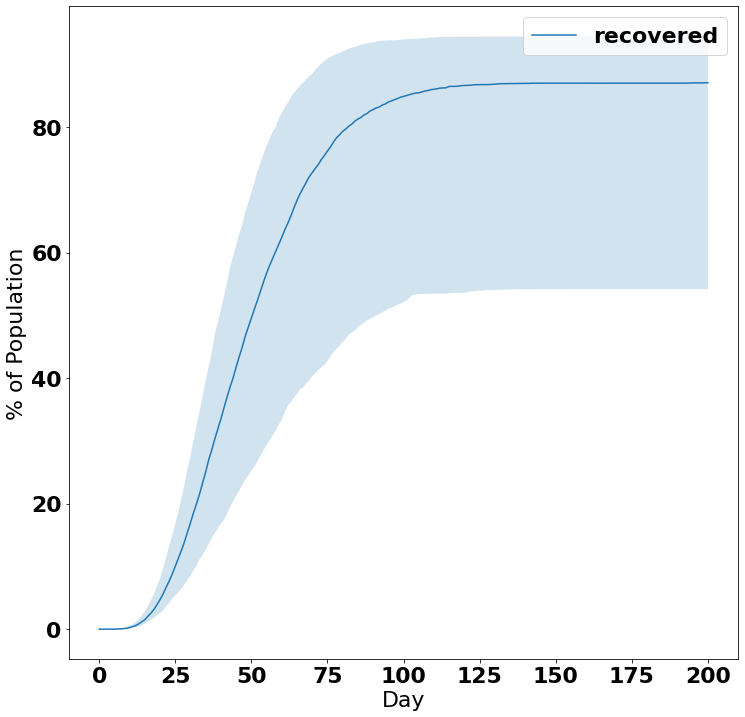

In [174]:
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
#plt.savefig(os.path.join(fig_dir, 'SIRD-Curve-100Replicates.png'))

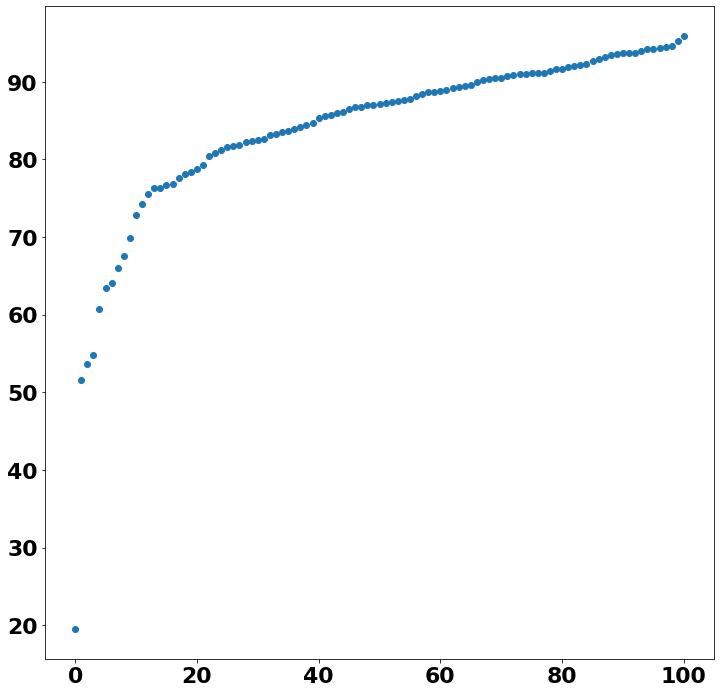

In [175]:
plt.scatter(range(101),
            [np.percentile(sird_counts, axis = 0, q = i)[4][-1] for i in range(101)]);

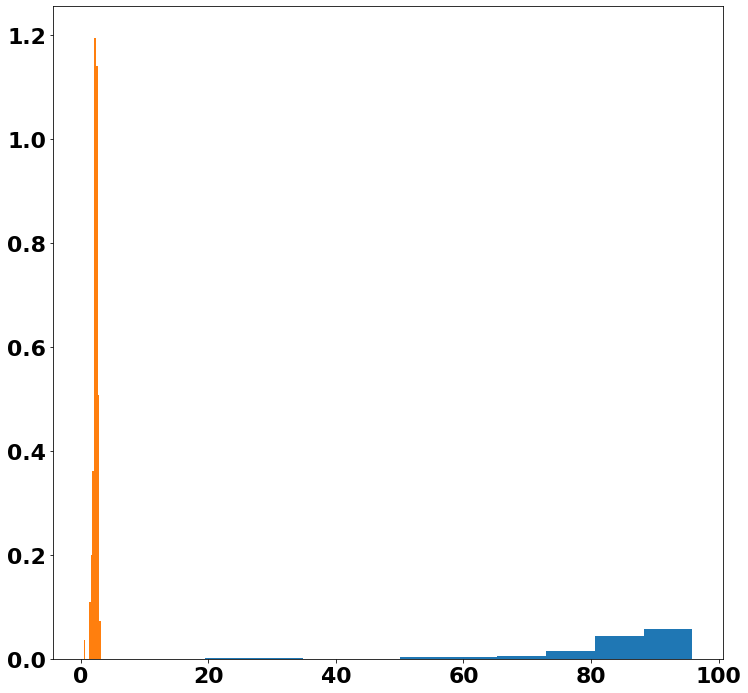

In [176]:
#plt.hist(sird_counts[:, 0, -1], density = True)
#plt.hist(sird_counts[:, 3, -1], density = True)
plt.hist(sird_counts[:, 4, -1], density = True);
plt.hist(sird_counts[:, 6, -1], density = True);

In [177]:
print(np.median(sird_counts[:, 4, -1]))
print(np.median(sird_counts[:, 5, -1]))
print(np.median(sird_counts[:, 6, -1]))

87.08
0.0
2.36


In [178]:
np.nanmean(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

2.8215397896141967

In [179]:
np.nanmedian(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

2.8077606299672766

In [180]:
np.nanstd(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]))

0.28359996864769277

In [181]:
np.nanpercentile(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]), 2.5)

2.267721894907543

In [182]:
np.nanpercentile(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]), 97.5)

3.3240228163419308

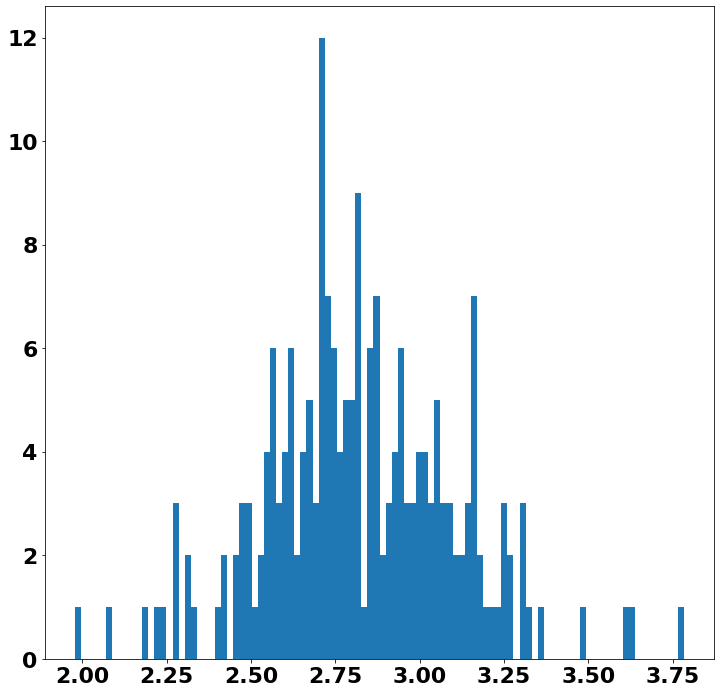

In [183]:
plt.hist(100 * sird_counts[:, 6, -1] / (sird_counts[:, 4, -1] - sird_counts[:, 6, -1]), bins = 100);

## Scenarios in Focus: Specific Testing Frequencies/Number of People

In [96]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 7)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)

In [97]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 0

width = 32
height = 32

# R0 = 2.5 == 32 * 32
# R0 = 2 == 34 * 35
# R0 = 1.5 == 39 * 39

scenario = scenario_weekly

n_cores = 20

In [98]:
states, costs = MultiProcessorRunCustom(replicates,
                                        max_steps,
                                        N_t, N_i, N_r,
                                        width, height,
                                        scenario_weekly, mitigation_strategy_r,
                                        n_cores)

In [99]:
sird_counts = np.ones((replicates, 8, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [100]:
with open(os.path.join(out_dir,
                       '5000Agents-200Replicates-SIRD_counts-WeeklyWholePopRT-PCR.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs), handle, protocol = pickle.HIGHEST_PROTOCOL)

In [137]:
with open(os.path.join(out_dir,
                           '5000Agents-200Replicates-SIRD_counts-WeeklyWholePopRT-PCR.pickle'),
              'rb') as openfile:
        sird_counts, costs = pickle.load(openfile)

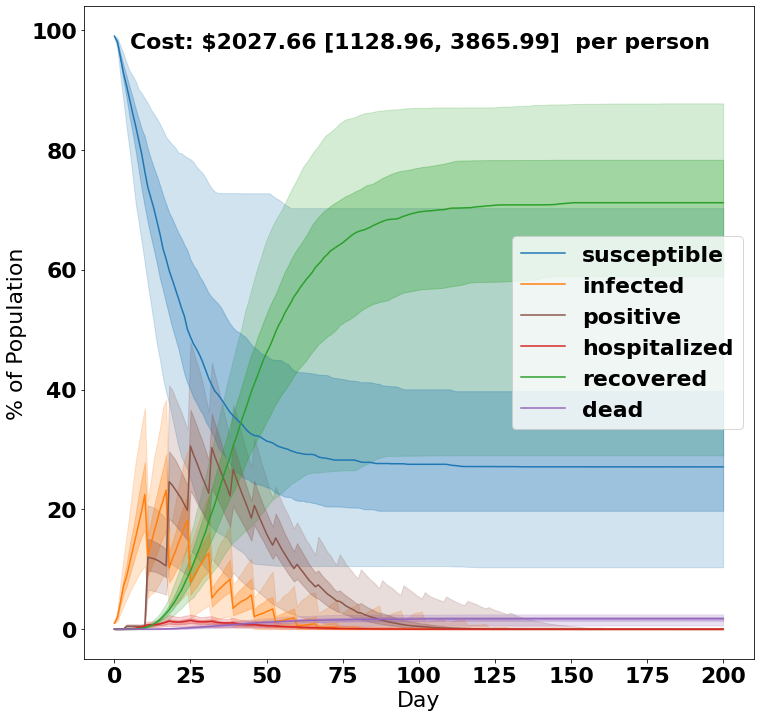

In [141]:
# look at the sird curve for multiple runs (should add "E" at some point)
plt.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible', color = "C{}".format(0));
plt.plot((np.median(sird_counts, axis = 0)[3]), label = 'infected', color = "C{}".format(1));
plt.plot(np.median(sird_counts, axis = 0)[4], label = 'positive', color = "C{}".format(5));
plt.plot(np.median(sird_counts, axis = 0)[7], label = 'hospitalized', color = "C{}".format(3));
plt.plot(np.median(sird_counts, axis = 0)[5], label = 'recovered', color = "C{}".format(2));
plt.plot(np.median(sird_counts, axis = 0)[6], label = 'dead', color ="C{}".format(4));

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2, color = "C{}".format(0))
plt.fill_between(range(max_steps), (np.percentile(sird_counts, axis = 0, q = 2.5)[3]),
                 (np.percentile(sird_counts, axis = 0, q = 97.5)[3]), alpha = 0.2, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2, color = "C{}".format(5))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2, color = "C{}".format(4))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[7],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[7], alpha = 0.2, color = "C{}".format(3))

plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
                 np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))
plt.fill_between(range(max_steps), (np.percentile(sird_counts, axis = 0, q = 25)[3]),
                 (np.percentile(sird_counts, axis = 0, q = 75)[3]), alpha = 0.3, color = "C{}".format(1))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(5))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(2))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))
plt.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[7],
                 np.percentile(sird_counts, axis = 0, q = 75)[7], alpha = 0.3, color = "C{}".format(3))

plt.text(5, 97, 'Cost: $' + str(round(np.median(costs) / 5000, 2)) + ' [' + str(round(np.percentile(costs, 2.5) / 5000, 2)) + ', ' + str(round(np.percentile(costs, 97.5) / 5000, 2)) + '] ' + ' per person')

plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');
plt.savefig(os.path.join(fig_dir, 'WeeklyWholePopulationRT-PCRTesting50th95thPercentilesCost.png'))
plt.savefig(os.path.join(fig_dir, 'WeeklyWholePopulationRT-PCRTesting50th95thPercentilesCost.pdf'))

In [120]:
np.median(costs)

2484360.0

In [121]:
np.percentile(costs, q = 2.5)

1480873.5

In [122]:
np.percentile(costs, q = 97.5)

6209955.000000005

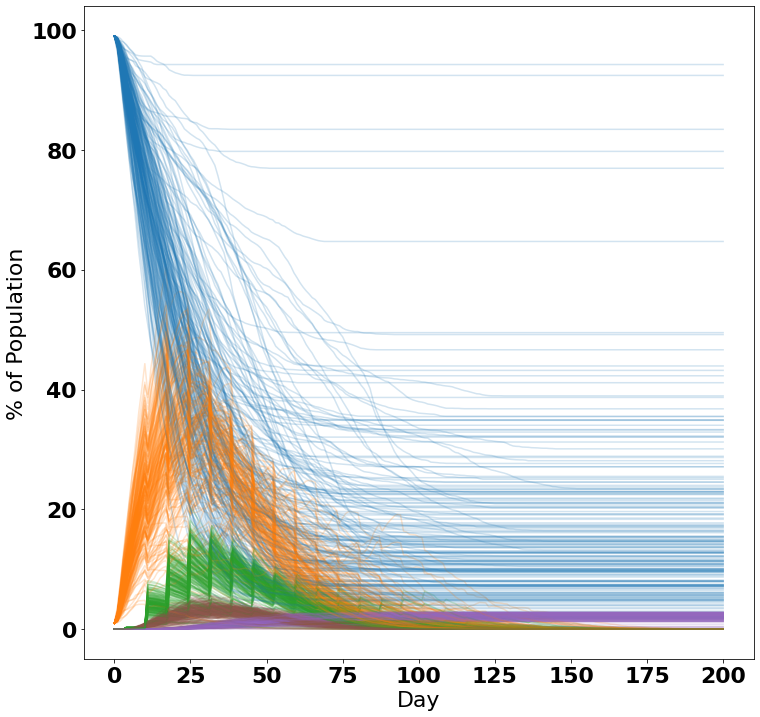

In [123]:
for i in range(replicates):
    plt.plot(sird_counts[i, 0, :].T, c = "C{}".format(0), alpha = .2)
    plt.plot(sird_counts[i, 3, :].T, c = "C{}".format(1), alpha = .2)
    plt.plot(sird_counts[i, 4, :].T, c = "C{}".format(2), alpha = .2)
    plt.plot(sird_counts[i, 6, :].T, c = "C{}".format(4), alpha = .2)
    plt.plot(sird_counts[i, 7, :].T, c = "C{}".format(5), alpha = .2)

plt.ylabel('% of Population');
plt.xlabel('Day');
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-500Replicates.png'))
#plt.savefig(os.path.join(fig_dir, 'NoMitigation-IndividualRuns-5000Agents-500Replicates.pdf'))

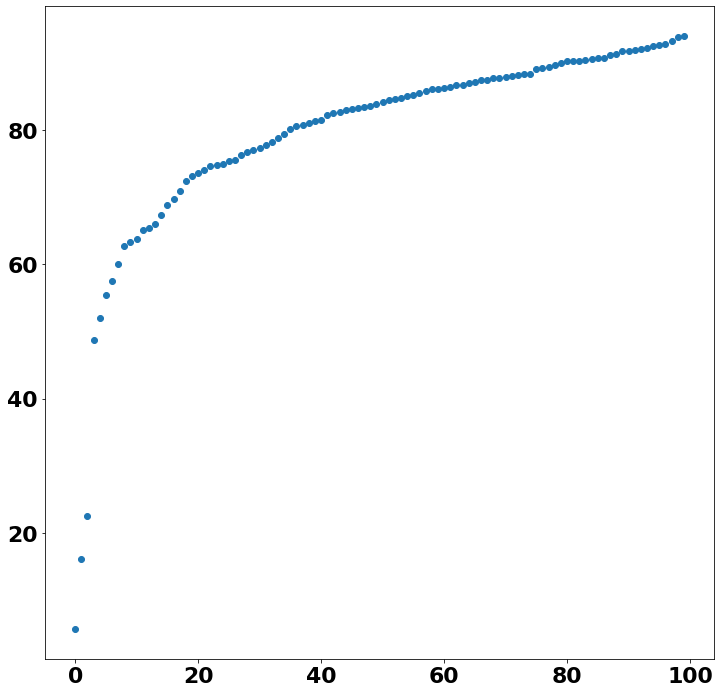

In [124]:
plt.scatter(range(100),
            [np.percentile(sird_counts, axis = 0, q = i)[5][-1] for i in range(100)])

## Various Cost and Efficacy Scenarios

In [96]:
replicates = 200
max_steps = 201

N_t = 5000
N_i = 50
N_r = 0

width = 32
height = 32

n_cores = 60

In [ ]:
costs = np.ones((10, 8, replicates))
deaths = np.ones((10, 8, replicates))
total_cases = np.ones((10, 8, replicates))
total_recovered = np.ones((10, 8, replicates))

for groups in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for idx, frequency in enumerate([1, 3, 5, 7, 9, 11, 13, 15]):
        mitigation_strategy_r = mitigation(testing_effectiveness, groups = groups, period = frequency)

        scenario_temp = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.0,
                                     steps_per_day = 1)
        
        states, ccc = MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height,
                                                scenario_temp,
                                                mitigation_strategy_r,
                                                n_cores)
        
        sird_counts = np.ones((replicates, 3, max_steps))

        for j in range(replicates):
            for i in range(max_steps):
                sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
                sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
                sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        
        sird_counts = sird_counts * 100 / N_t
        
        deaths[groups - 1, idx, :] = sird_counts[:, 2, -1]
        
        total_cases[groups - 1, idx, :] = np.sum(sird_counts[:, 0, :], axis = 1)
        
        total_recovered[groups - 1, idx, :] = sird_counts[:, 1, -1]
        
        costs[groups - 1, idx, :] = np.array(ccc)
        
    print(str(groups) + str(frequency))


13



23



33


In [99]:
with open(os.path.join(out_dir, 'Grid-RT-PCR-9--1-3.pickle'), 'wb') as handle:
    pickle.dump({'deaths' : deaths,
                'total_cases' : total_cases,
                'total_recovered' : total_recovered,
                'costs' : costs}, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Analysis

### RT-PCR - US

In [5]:
deaths = list()
total_cases = list()
total_recovered = list()
costs = list()
for i in range(1, 9):
    with open(os.path.join(out_dir, 'Grid-RT-PCR-' + str(i) + 'All.pickle'), 'rb') as openfile:
        tt1 = pickle.load(openfile)
        deaths.append(tt1['deaths'])
        total_cases.append(tt1['total_cases'])
        total_recovered.append(tt1['total_recovered'])
        costs.append(tt1['costs'])

In [6]:
costs_r_u = np.concatenate(tuple(costs), axis = 2)
deaths_r_u = np.concatenate(tuple(deaths), axis = 2)
total_cases_r_u = np.concatenate(tuple(total_cases), axis = 2)
total_recovered_r_u = np.concatenate(tuple(total_recovered), axis = 2)

In [7]:
# correct the first two frequencies which had a bug in them when run initially
with open(os.path.join(out_dir, 'Grid-RT-PCR-9--1-3.pickle'), 'rb') as openfile:
    tt1 = pickle.load(openfile)

In [8]:
costs_r_u[:, [0, 1], :] = tt1['costs']
deaths_r_u[:, [0, 1], :] = tt1['deaths']
total_cases_r_u[:, [0, 1], :] = tt1['total_cases']
total_recovered_r_u[:, [0, 1], :] = tt1['total_recovered']

In [9]:
# normalize by the sum of infected in no mitigation
with open(os.path.join(out_dir, 'NoMitigation/5000Agents-200Replicates-SIRD_counts.pickle'), 'rb') as openfile:
    tt1 = pickle.load(openfile)

In [10]:
(np.percentile(total_cases_r_u, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))).max()

109.32321570947894

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


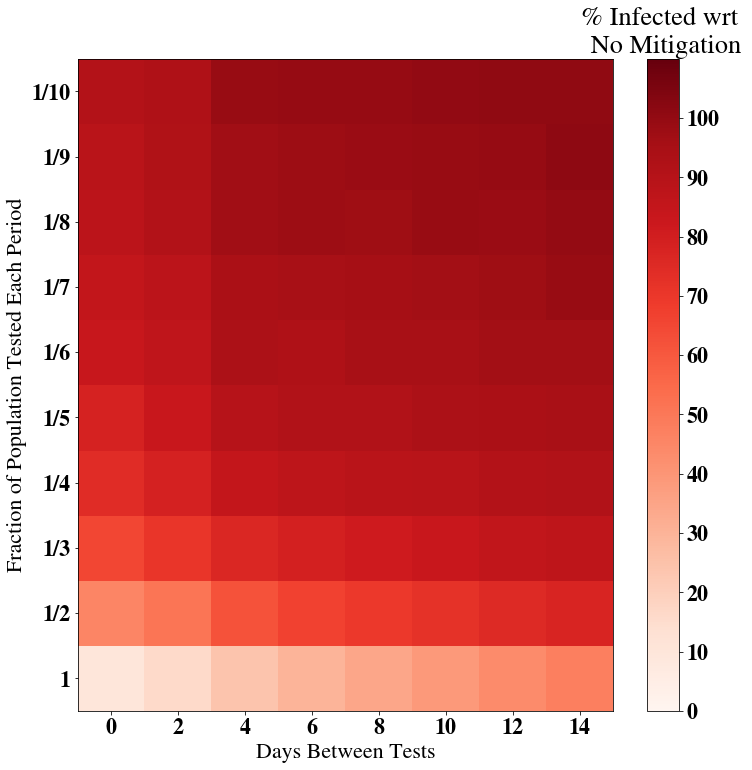

In [11]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.median(total_cases_r_u, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


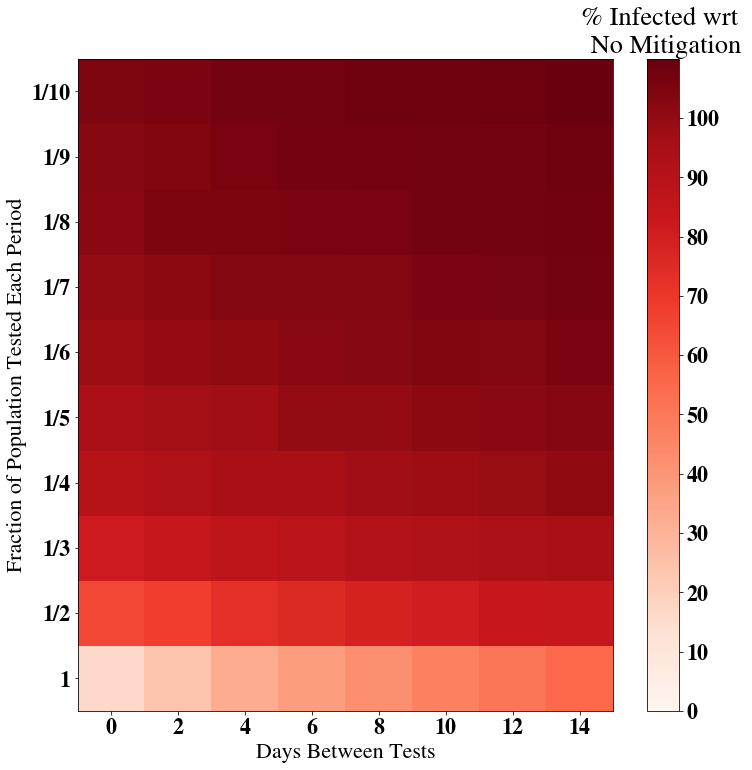

In [12]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_r_u, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-UB-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT_PCR-UB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


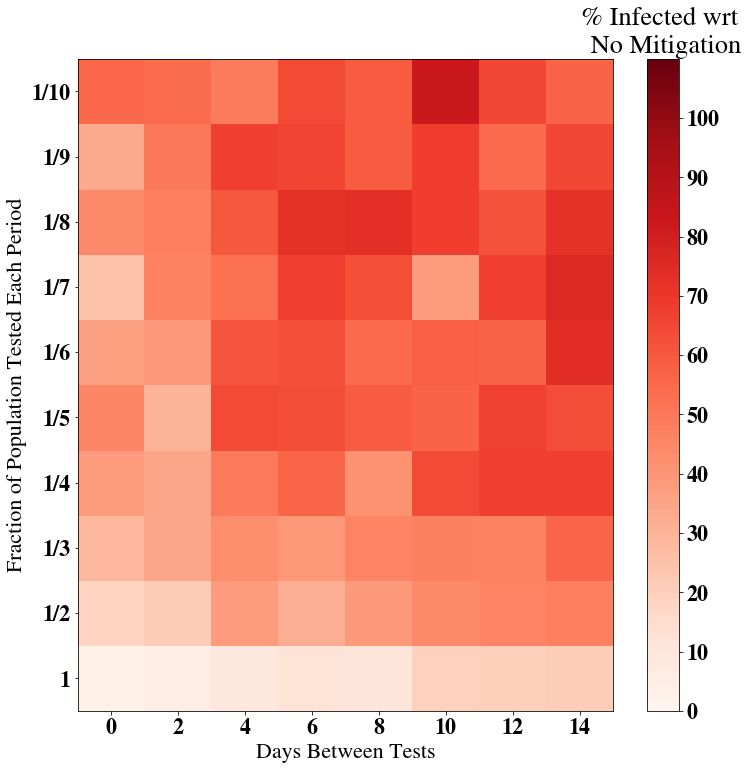

In [13]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_r_u, axis = 2, q = 2.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-LB-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-LB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


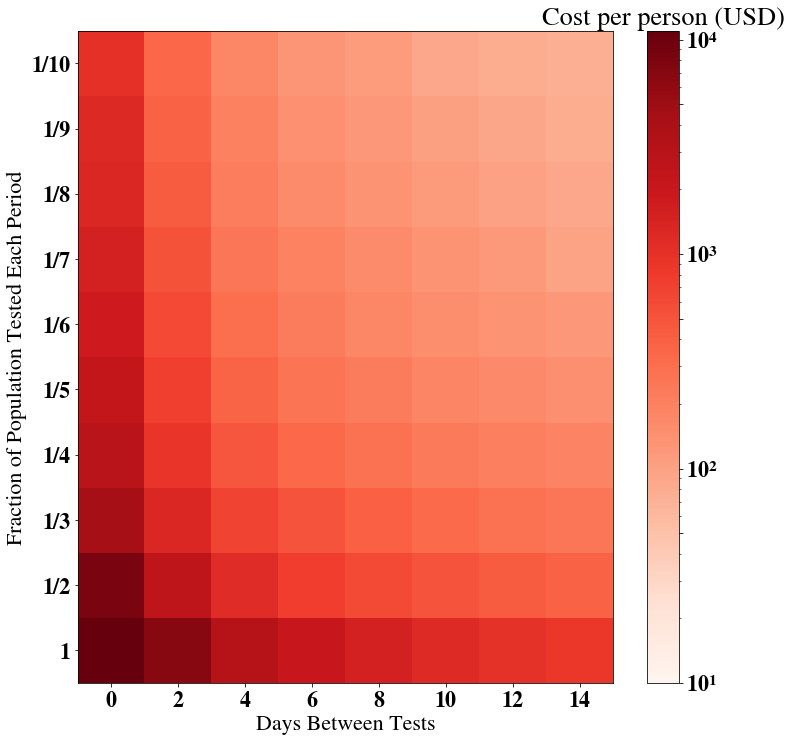

In [14]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.median(costs_r_u, axis = 2) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 11000),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000, 5000, 10000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


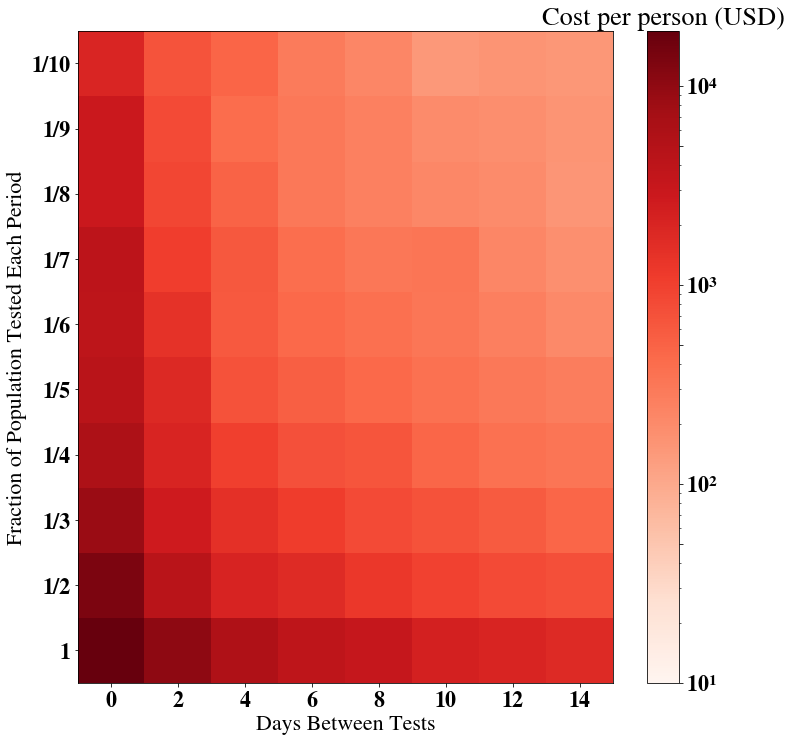

In [15]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_r_u, axis = 2, q = 97.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 19000),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000, 5000, 10000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-UB-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-UB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


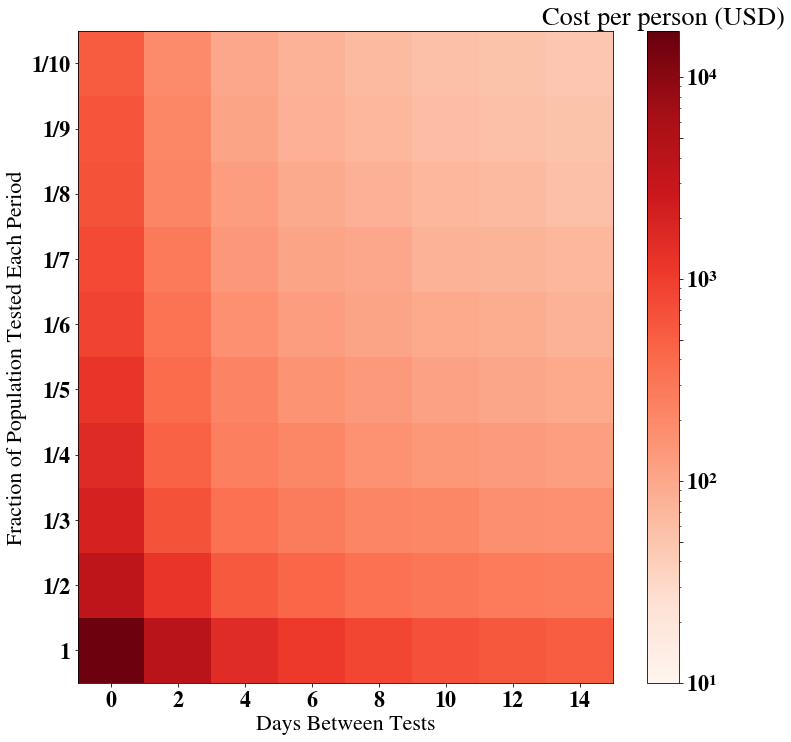

In [16]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_r_u, axis = 2, q = 2.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 17000),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000, 5000, 10000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-LB-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-LB-US.pdf'))

In [17]:
yy1 = (np.median(total_cases_r_u,
                 axis = 2).flatten()) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

In [18]:
# frequency
xx1 = (np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10))

In [19]:
# number of people
xx2 = 1/(np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8))

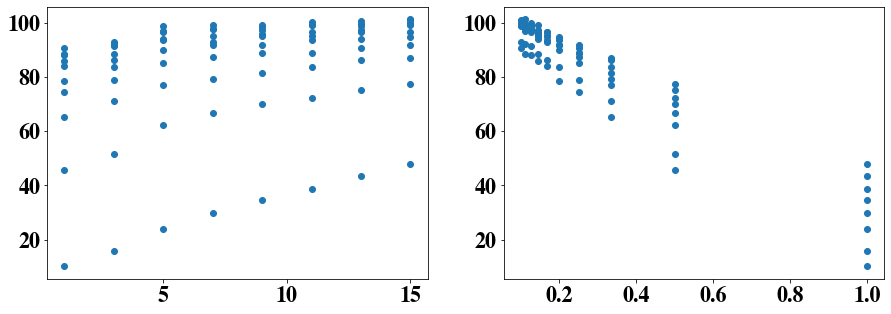

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].scatter(xx1, yy1)
ax[1].scatter(xx2, yy1)

In [21]:
# , np.ones((80, 1))
xx3 = np.concatenate([(xx1.reshape(80, 1) - np.mean(xx1)) / np.std(xx1),
                      (xx2.reshape(80, 1) - np.mean(xx2)) / np.std(xx2)], axis = 1)

In [22]:
r_u = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

In [23]:
r_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1232.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    9.66e-60
Time:                        13:10:57   Log-Likelihood:                          25.856
No. Observations:                  80   AIC:                                     -47.71
Df Residuals:                      78   BIC:                                     -42.95
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2744      0.020     13.838      0.000       0.235       0.314
x2            -0.9455      0.020    -47.678      0.000      -0.985      -0.906
==============================================================================
Omnibus:                       13.275   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.838
Skew:                          -0.725   Prob(JB):                     0.000134
Kurtosis:                       4.802   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

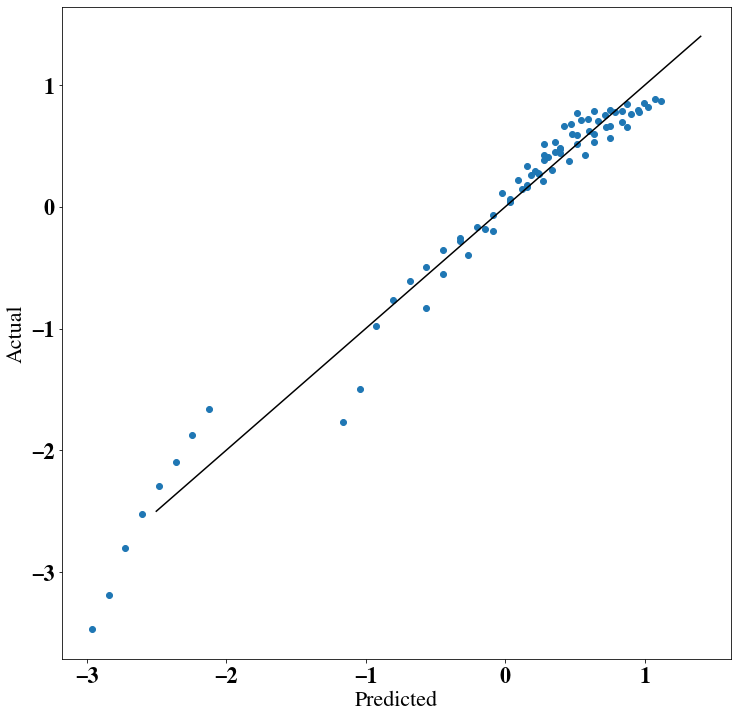

In [24]:
plt.scatter((r_u.predict(xx3)), (yy1 - np.mean(yy1)) / np.std(yy1))
plt.plot(np.arange(-2.5, 1.5, 0.1), np.arange(-2.5, 1.5, 0.1), c = 'k')
plt.xlabel('Predicted');
plt.ylabel('Actual');

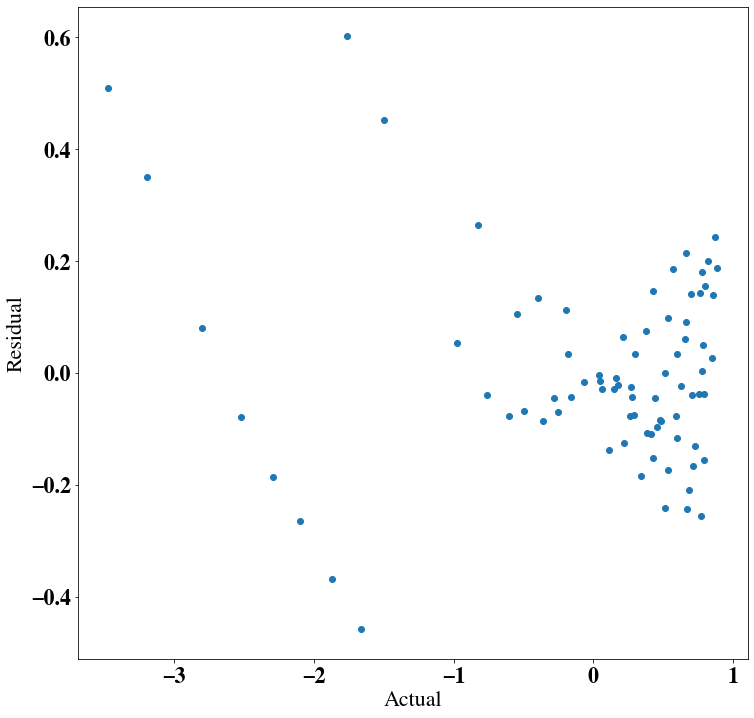

In [25]:
plt.scatter((yy1 - np.mean(yy1)) / np.std(yy1), (r_u.predict(xx3)) - (yy1 - np.mean(yy1)) / np.std(yy1))
plt.ylabel('Residual');
plt.xlabel('Actual');

### Antigen - US

In [26]:
deaths = list()
total_cases = list()
total_recovered = list()
costs = list()
for i in range(1, 9):
    with open(os.path.join(out_dir, 'Grid-Antigen-' + str(i) + 'All.pickle'), 'rb') as openfile:
        tt1 = pickle.load(openfile)
        deaths.append(tt1['deaths'])
        total_cases.append(tt1['total_cases'])
        total_recovered.append(tt1['total_recovered'])
        costs.append(tt1['costs'])

In [27]:
costs_a_u = np.concatenate(tuple(costs), axis = 2)
deaths_a_u = np.concatenate(tuple(deaths), axis = 2)
total_cases_a_u = np.concatenate(tuple(total_cases), axis = 2)
total_recovered_a_u = np.concatenate(tuple(total_recovered), axis = 2)

In [28]:
# normalize by the sum of infected in no mitigation
with open(os.path.join(out_dir, 'NoMitigation/5000Agents-200Replicates-SIRD_counts.pickle'), 'rb') as openfile:
    tt1 = pickle.load(openfile)

In [29]:
np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

1994.21

In [30]:
(np.median(total_cases_a_u, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))).min()

0.3971497485219711

In [31]:
(np.percentile(total_cases_a_u, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))).max()

111.99851068844303

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


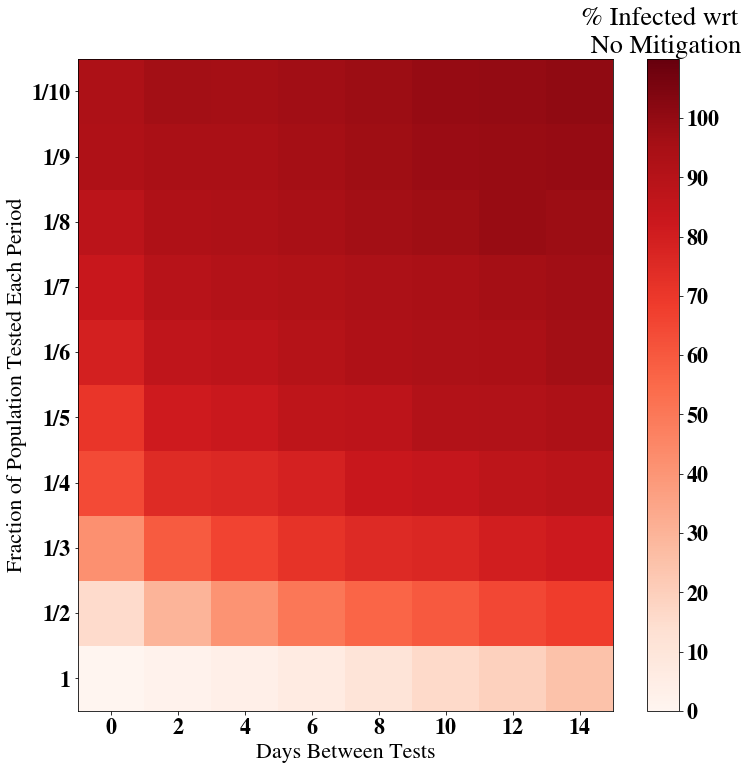

In [32]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.median(total_cases_a_u, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


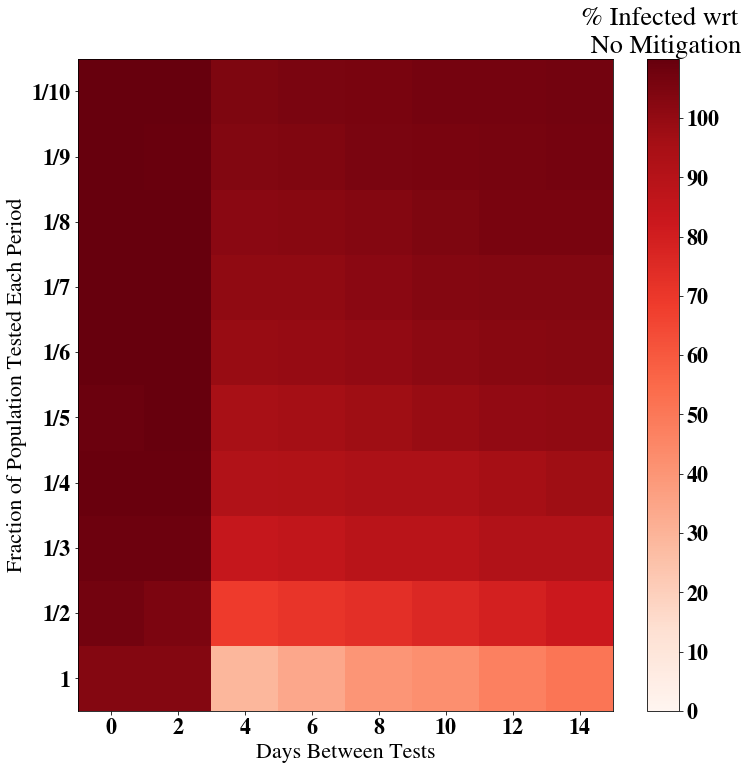

In [33]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_a_u, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-UB-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-UB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


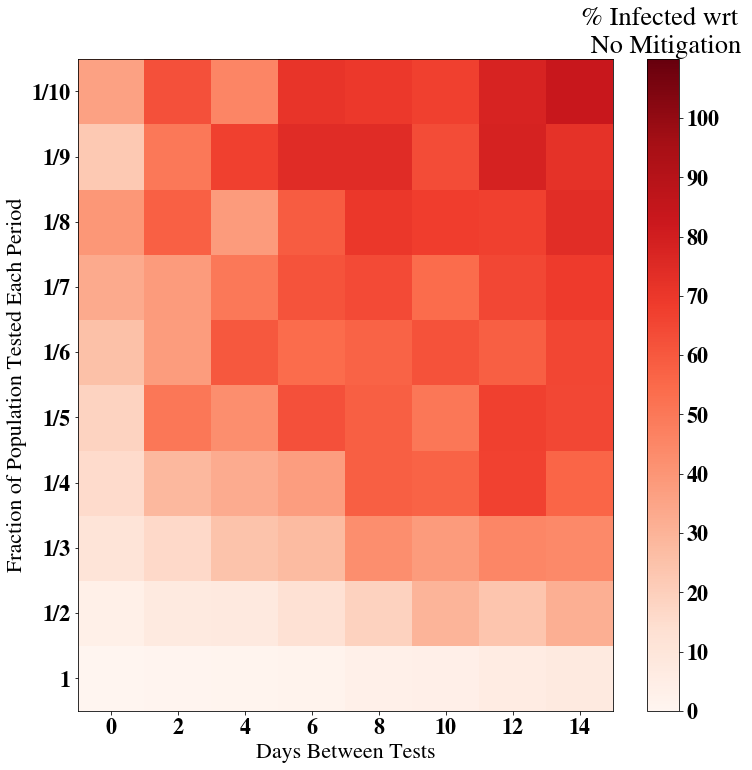

In [34]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_a_u, axis = 2, q = 2.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-LB-US.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-LB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


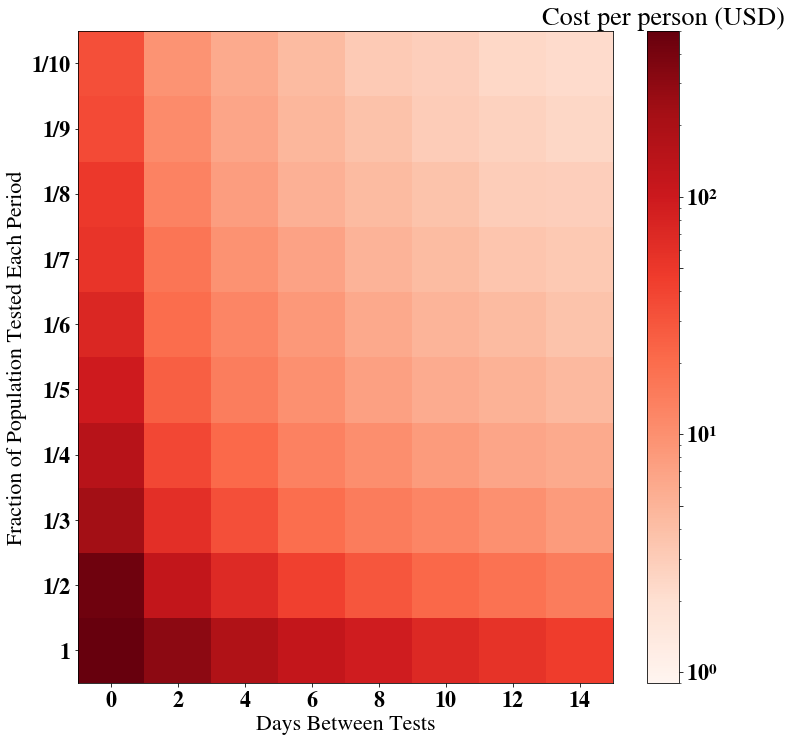

In [35]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.median(costs_a_u, axis = 2) / 5000,
           norm = mpl.colors.LogNorm(vmin = 0.9, vmax = 500),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [1, 5, 10, 50, 100]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


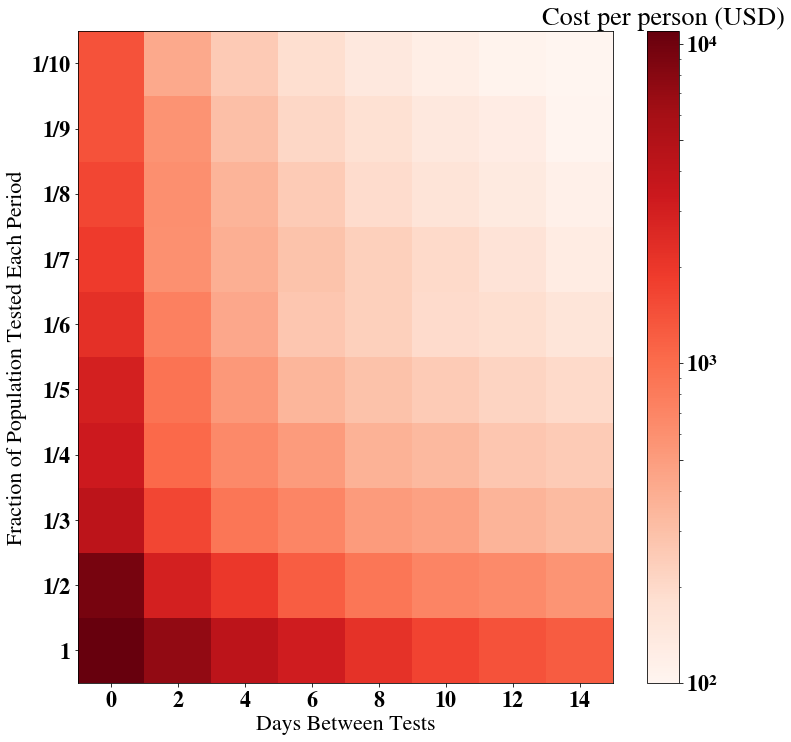

In [36]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_a_u, axis = 2, q = 97.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 100, vmax = 11000),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [100, 500, 1000, 5000, 10000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-UB-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-UB-US.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


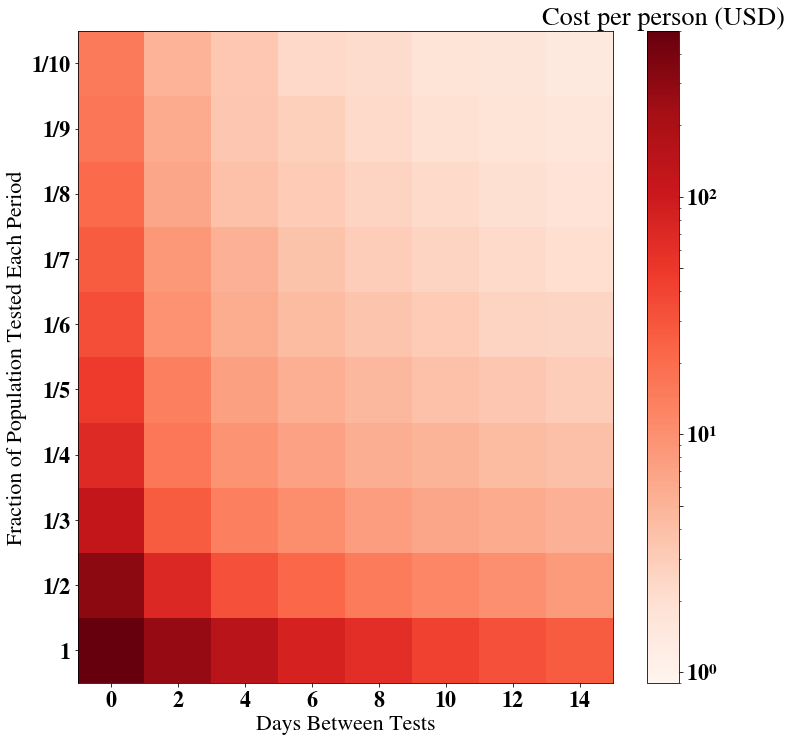

In [37]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_a_u, axis = 2, q = 2.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 0.9, vmax = 500),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [1, 5, 10, 50, 100]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-LB-US.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-LB-US.pdf'))

In [38]:
yy1 = np.median(total_cases_a_u,
                axis = 2).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

In [39]:
# frequency
xx1 = (np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10))

In [40]:
# number of people
xx2 = 1/(np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8))

In [41]:
# , np.ones((80, 1))
xx3 = np.concatenate([(xx1.reshape(80, 1) - np.mean(xx1)) / np.std(xx1),
                      (xx2.reshape(80, 1) - np.mean(xx2)) / np.std(xx2)], axis = 1)

In [42]:
a_u = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

In [43]:
a_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              807.8
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    7.37e-53
Time:                        13:11:04   Log-Likelihood:                          9.6018
No. Observations:                  80   AIC:                                     -15.20
Df Residuals:                      78   BIC:                                     -10.44
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2402      0.024      9.886      0.000       0.192       0.289
x2            -0.9467      0.024    -38.960      0.000      -0.995      -0.898
==============================================================================
Omnibus:                       64.777   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.359
Skew:                          -2.505   Prob(JB):                     1.03e-80
Kurtosis:                      12.242   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

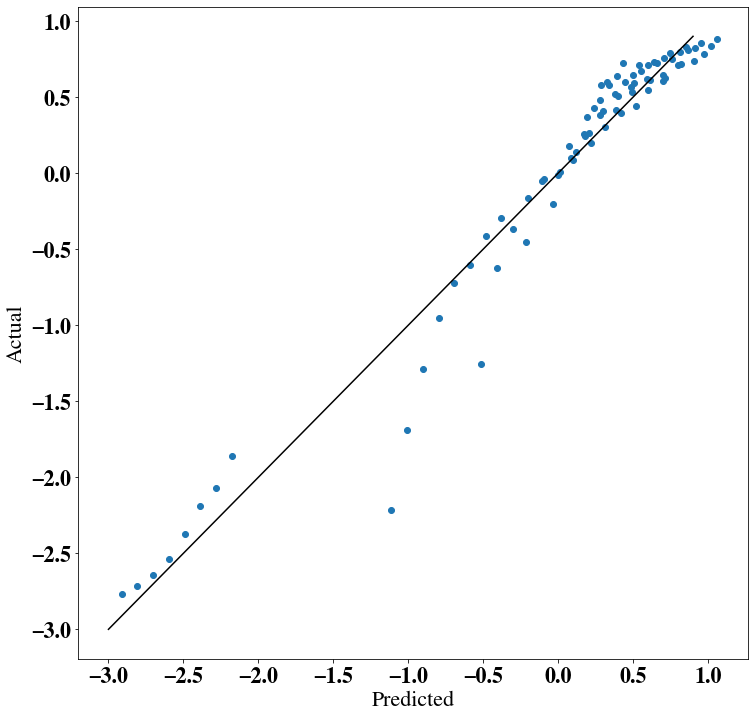

In [44]:
plt.scatter((a_u.predict(xx3)), (yy1 - np.mean(yy1)) / np.std(yy1))
plt.plot(np.arange(-3, 1, 0.1), np.arange(-3, 1, 0.1), c = 'k')
plt.xlabel('Predicted');
plt.ylabel('Actual');

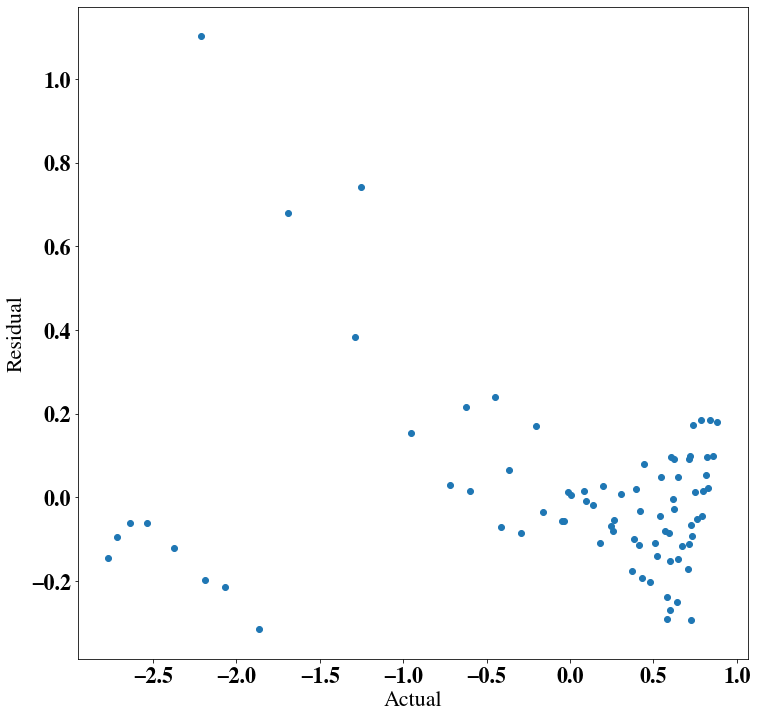

In [46]:
plt.scatter((yy1 - np.mean(yy1)) / np.std(yy1), (a_u.predict(xx3)) - (yy1 - np.mean(yy1)) / np.std(yy1))
plt.ylabel('Residual');
plt.xlabel('Actual');

In [47]:
yy1 = np.concatenate([np.percentile(total_cases_a_u,
                axis = 2, q = 50).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50)),
                     np.percentile(total_cases_r_u,
                axis = 2, q = 50).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))],
                     axis = 0)

# frequency
xx1 = np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10).reshape(80, 1)

xx1 = np.concatenate([xx1, xx1], axis = 0)

# number of people
xx2 = 1/np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8).reshape(80, 1)

xx2 = np.concatenate([xx2, xx2], axis = 0)

# , np.ones((80, 1))
xx3 = np.concatenate([(xx1 - np.mean(xx1)) / np.std(xx1),
                      (xx2 - np.mean(xx2)) / np.std(xx2),
                      np.array([*np.repeat(0, 80), *np.repeat(1, 80)]).reshape(160, 1)], axis = 1)

u = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              763.1
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    2.33e-93
Time:                        13:11:19   Log-Likelihood:                         -7.3436
No. Observations:                 160   AIC:                                      20.69
Df Residuals:                     157   BIC:                                      29.91
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2506      0.020     12.397      0.000       0.211       0.291
x2            -0.9300      0.020    -46.000      0.000      -0.970      -0.890
x3             0.1265      0.029      4.426      0.000       0.070       0.183
==============================================================================
Omnibus:                       75.217   Durbin-Watson:                   0.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              581.543
Skew:                          -1.490   Prob(JB):                    5.24e-127
Kurtosis:                      11.851   Cond. No.                         1.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
(.1265 * np.std(yy1))

3.1172059521974074

In [49]:
u.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.935   
Dependent Variable:     y                AIC:                         20.6872 
Date:                   2020-12-24 13:11 BIC:                         29.9127 
No. Observations:       160              Log-Likelihood:              -7.3436 
Df Model:               3                F-statistic:                 763.1   
Df Residuals:           157              Prob (F-statistic):          2.33e-93
R-squared (uncentered): 0.936            Scale:                       0.065405
-----------------------------------------------------------------------------------
           Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         0.2506        0.0202       12.3971      0.0000       0.2107       0.2906
x2        -0.9300        0.0202      -46.0002      0.0000      -0.9700      -0.8901
x3         0.1265        0.0286        4.4256      0.0000       0.0701       0.1830
------------------------------------------------------------------------------
Omnibus:                  75.217           Durbin-Watson:              0.691  
Prob(Omnibus):            0.000            Jarque-Bera (JB):           581.543
Skew:                     -1.490           Prob(JB):                   0.000  
Kurtosis:                 11.851           Condition No.:              1      
==============================================================================

"""

### RT-PCR - India

In [53]:
deaths = list()
total_cases = list()
total_recovered = list()
costs = list()
for i in range(2, 12):
    with open(os.path.join(out_dir, 'Grid-RT-PCR-' + str(i) + 'All-India.pickle'), 'rb') as openfile:
        tt1 = pickle.load(openfile)
        deaths.append(tt1['deaths'])
        total_cases.append(tt1['total_cases'])
        total_recovered.append(tt1['total_recovered'])
        costs.append(tt1['costs'])

In [54]:
costs_r_i = np.concatenate(tuple(costs), axis = 2)
deaths_r_i = np.concatenate(tuple(deaths), axis = 2)
total_cases_r_i = np.concatenate(tuple(total_cases), axis = 2)
total_recovered_r_i = np.concatenate(tuple(total_recovered), axis = 2)

In [55]:
# normalize by the sum of infected in no mitigation
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-India.pickle'), 'rb') as openfile:
    tt1 = pickle.load(openfile)

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


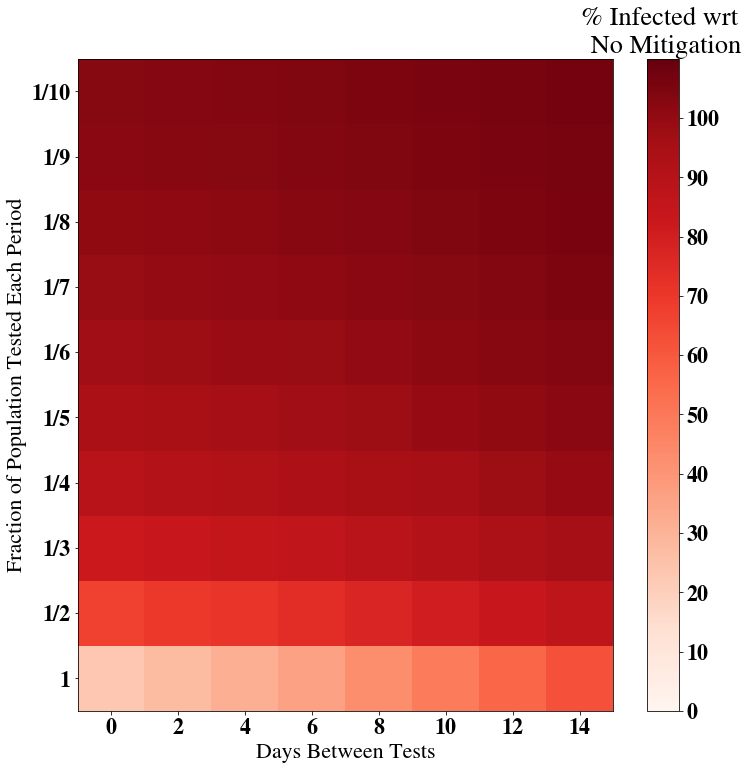

In [56]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.median(total_cases_r_i, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


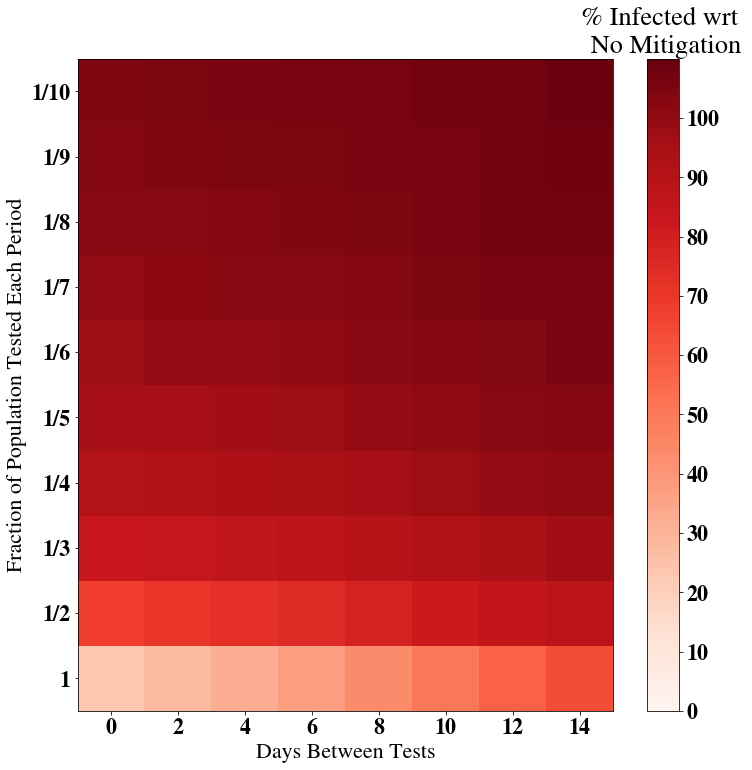

In [57]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_r_i, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-UB-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT_PCR-UB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


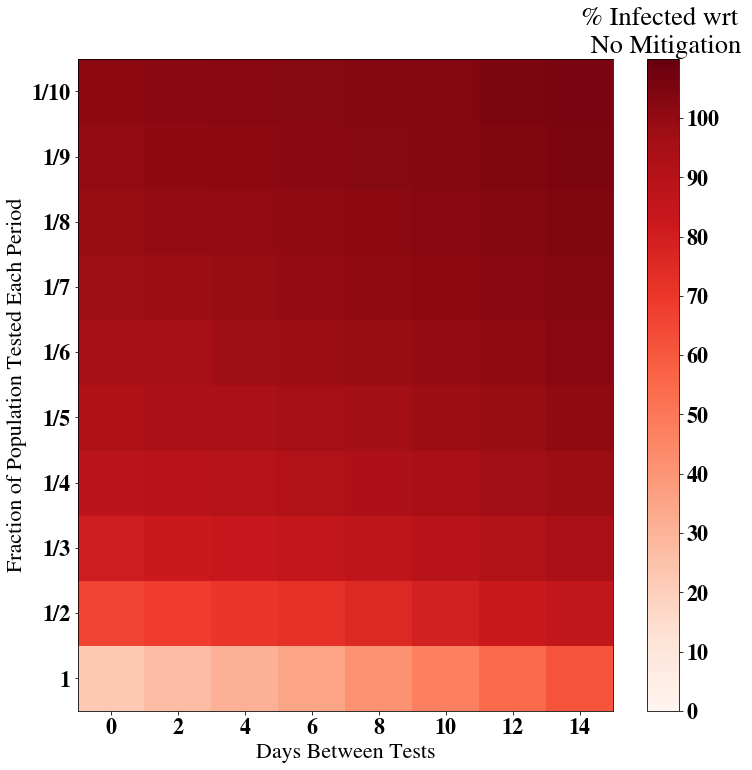

In [58]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_r_i, axis = 2, q = 2.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-LB-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-RT-PCR-LB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


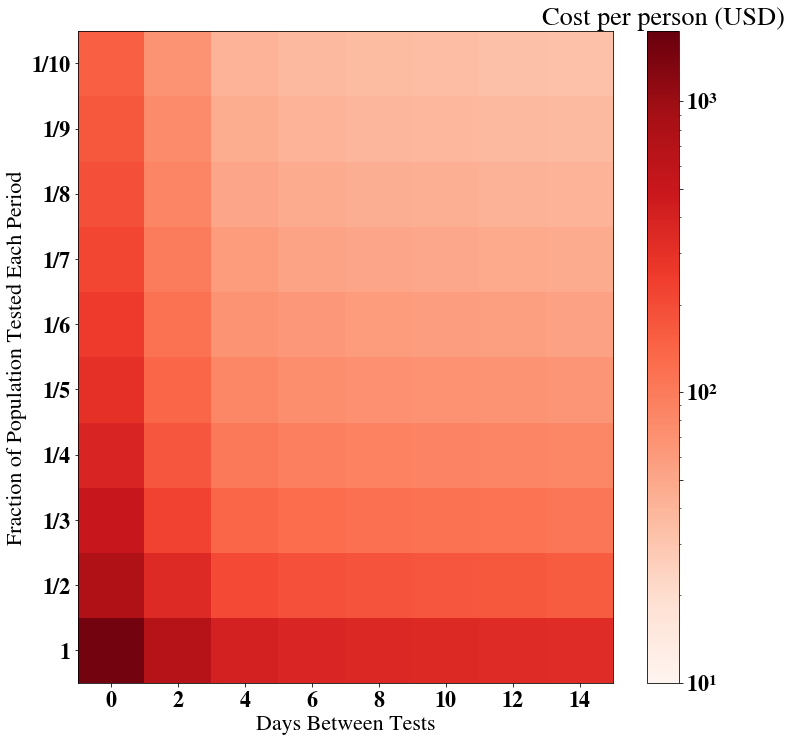

In [59]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.median(costs_r_i, axis = 2) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 1750),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


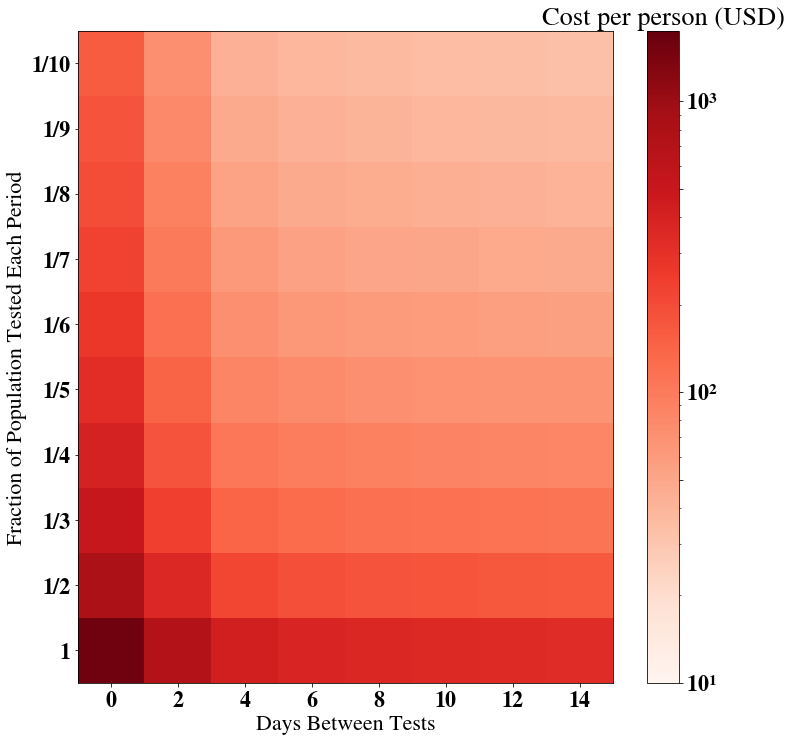

In [60]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_r_i, axis = 2, q = 97.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 1750),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-UB-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-UB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


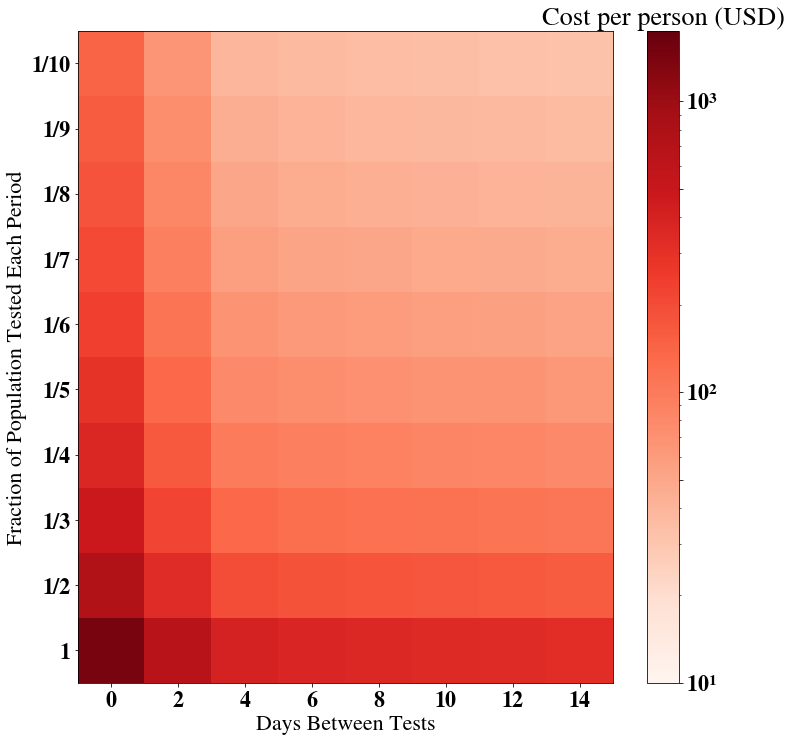

In [61]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_r_i, axis = 2, q = 2.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 10, vmax = 1750),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [10, 50, 100, 500, 1000]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-LB-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-RT-PCR-LB-India.pdf'))

In [62]:
yy1 = np.median(total_cases_r_i,
                axis = 2).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

In [63]:
# frequency
xx1 = np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10)

In [64]:
# number of people
xx2 = 1/np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8)

In [65]:
# , np.ones((80, 1))
xx3 = np.concatenate([(xx1.reshape(80, 1) - np.mean(xx1)) / np.std(xx1),
                      (xx2.reshape(80, 1) - np.mean(xx2)) / np.std(xx2)], axis = 1)

In [66]:
r_i = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

In [67]:
r_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1149.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    1.36e-58
Time:                        13:13:31   Log-Likelihood:                          23.146
No. Observations:                  80   AIC:                                     -42.29
Df Residuals:                      78   BIC:                                     -37.53
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1999      0.021      9.745      0.000       0.159       0.241
x2            -0.9629      0.021    -46.938      0.000      -1.004      -0.922
==============================================================================
Omnibus:                       25.455   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.737
Skew:                           0.649   Prob(JB):                     4.53e-31
Kurtosis:                       9.343   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

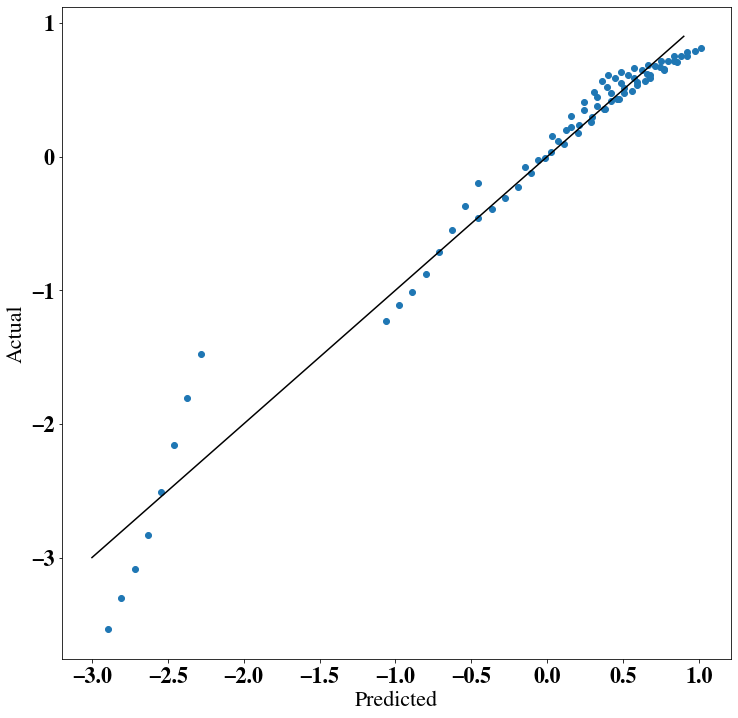

In [68]:
plt.scatter((r_i.predict(xx3)), (yy1 - np.mean(yy1)) / np.std(yy1))
plt.plot(np.arange(-3, 1, 0.1), np.arange(-3, 1, 0.1), c = 'k')
plt.xlabel('Predicted');
plt.ylabel('Actual');

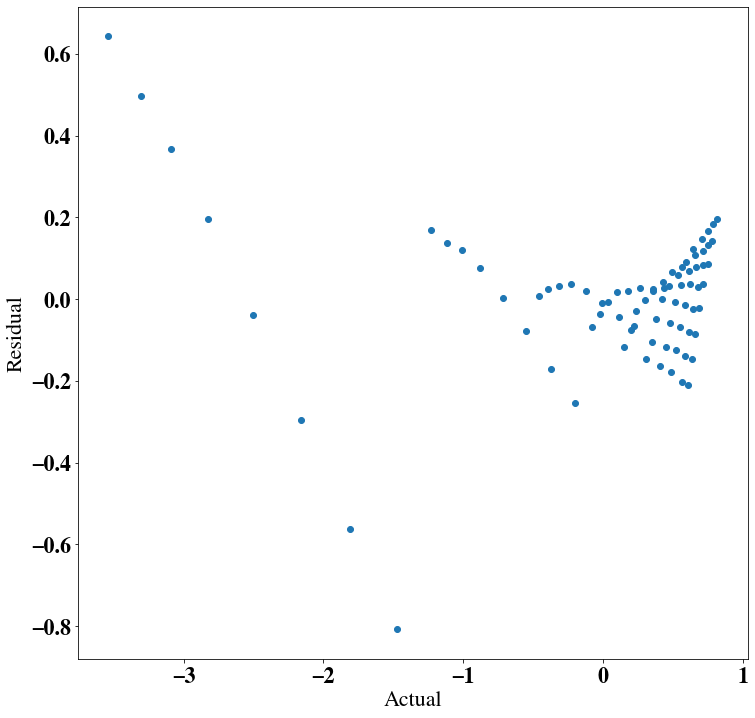

In [70]:
plt.scatter((yy1 - np.mean(yy1)) / np.std(yy1), (r_i.predict(xx3)) - (yy1 - np.mean(yy1)) / np.std(yy1))
plt.ylabel('Residual');
plt.xlabel('Actual');

### Antigen - India

In [71]:
deaths = list()
total_cases = list()
total_recovered = list()
costs = list()
for i in range(2, 12):
    with open(os.path.join(out_dir, 'Grid-Antigen-' + str(i) + 'All-India.pickle'), 'rb') as openfile:
        tt1 = pickle.load(openfile)
        deaths.append(tt1['deaths'])
        total_cases.append(tt1['total_cases'])
        total_recovered.append(tt1['total_recovered'])
        costs.append(tt1['costs'])

In [72]:
costs_a_i = np.concatenate(tuple(costs), axis = 2)
deaths_a_i = np.concatenate(tuple(deaths), axis = 2)
total_cases_a_i = np.concatenate(tuple(total_cases), axis = 2)
total_recovered_a_i = np.concatenate(tuple(total_recovered), axis = 2)

In [73]:
# normalize by the sum of infected in no mitigation
with open(os.path.join(out_dir, '5000Agents-200Replicates-SIRD_counts-India.pickle'), 'rb') as openfile:
    tt1 = pickle.load(openfile)

In [74]:
np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

2315.29

In [75]:
(np.median(total_cases_a_i, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))).min()

5.396732158822436

In [76]:
(np.median(total_cases_a_i, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))).max()

105.9046598914175

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


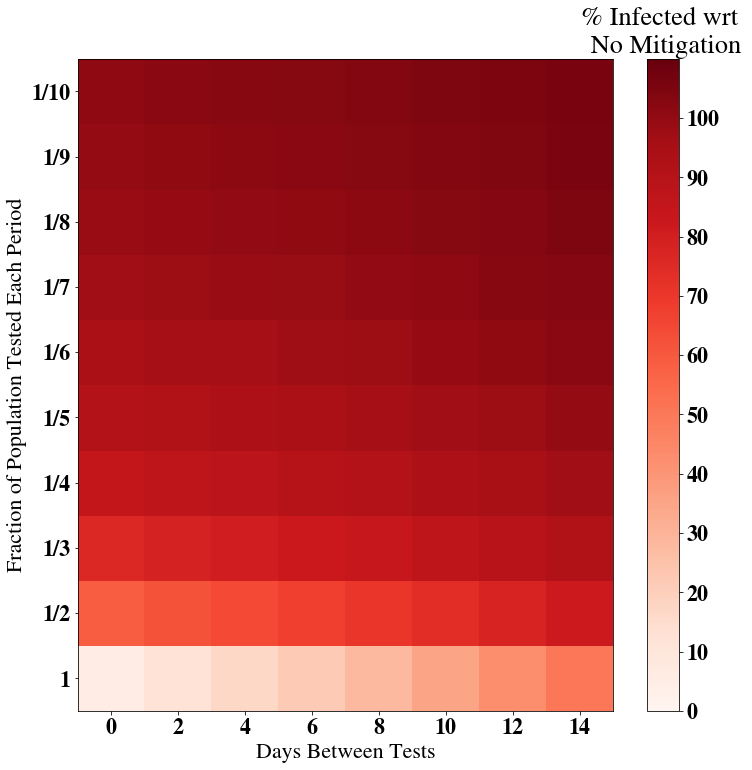

In [77]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.median(total_cases_a_i, axis = 2) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


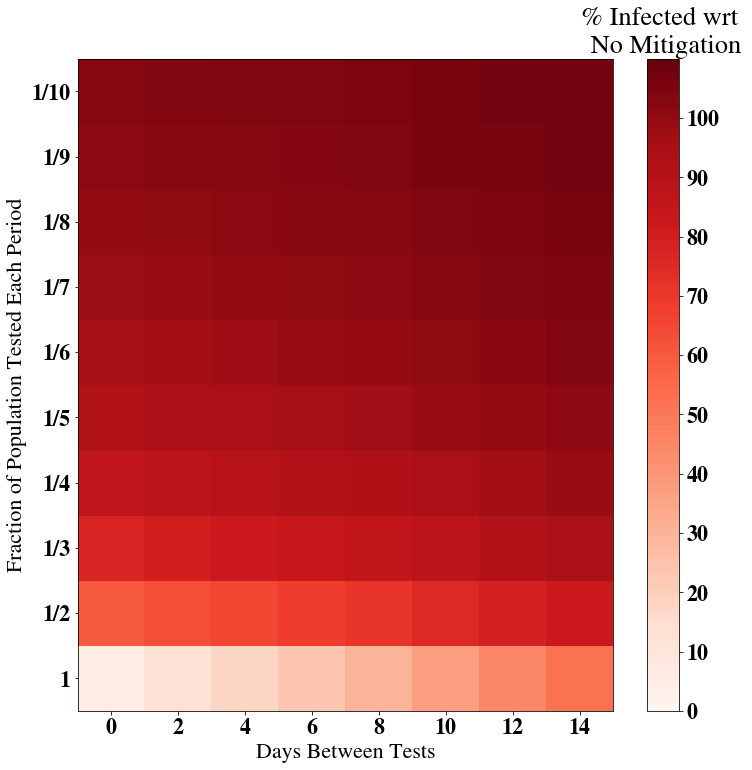

In [78]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_a_i, axis = 2, q = 97.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-UB-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-UB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


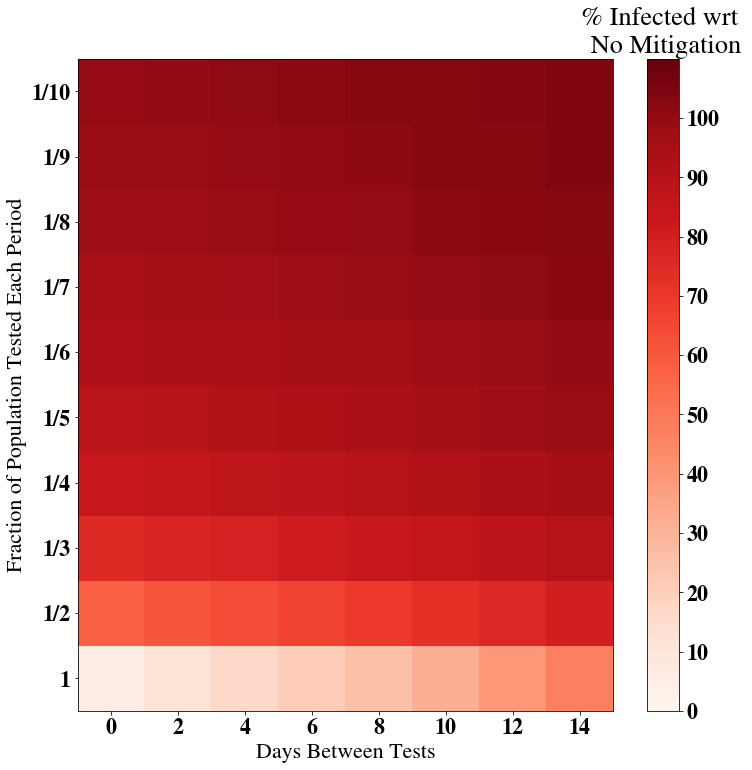

In [79]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           (np.percentile(total_cases_a_i, axis = 2, q = 2.5) * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))),
           norm = mpl.colors.Normalize(vmin = 0, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).ax.set_title('% Infected wrt \n No Mitigation')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-LB-India.png'))
plt.savefig(os.path.join(fig_dir, 'TotalCasesVariousTestingScenarios-Antigen-LB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


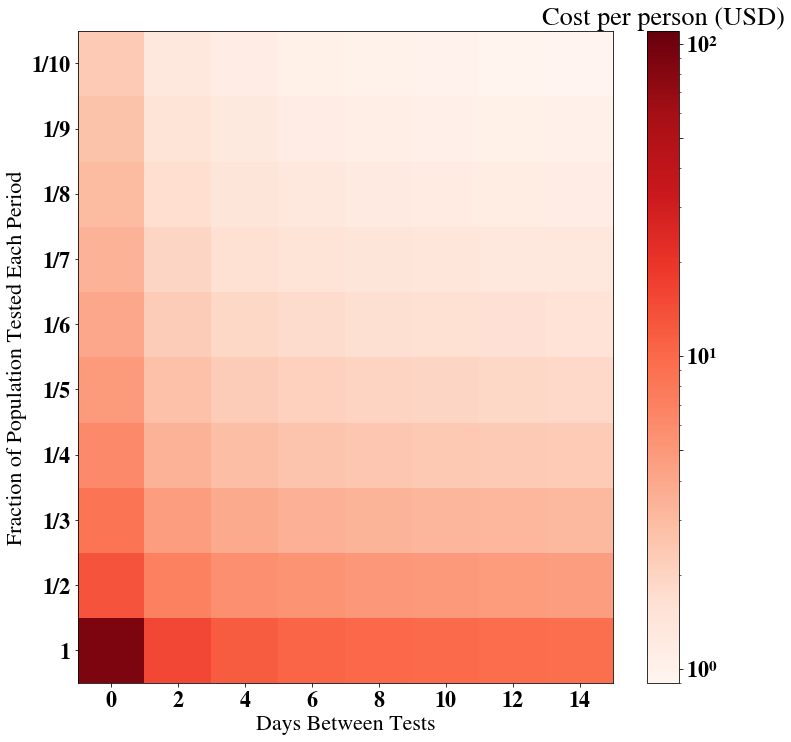

In [80]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.median(costs_a_i, axis = 2) / 5000,
           norm = mpl.colors.LogNorm(vmin = 0.9, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [1, 5, 10, 50, 100]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


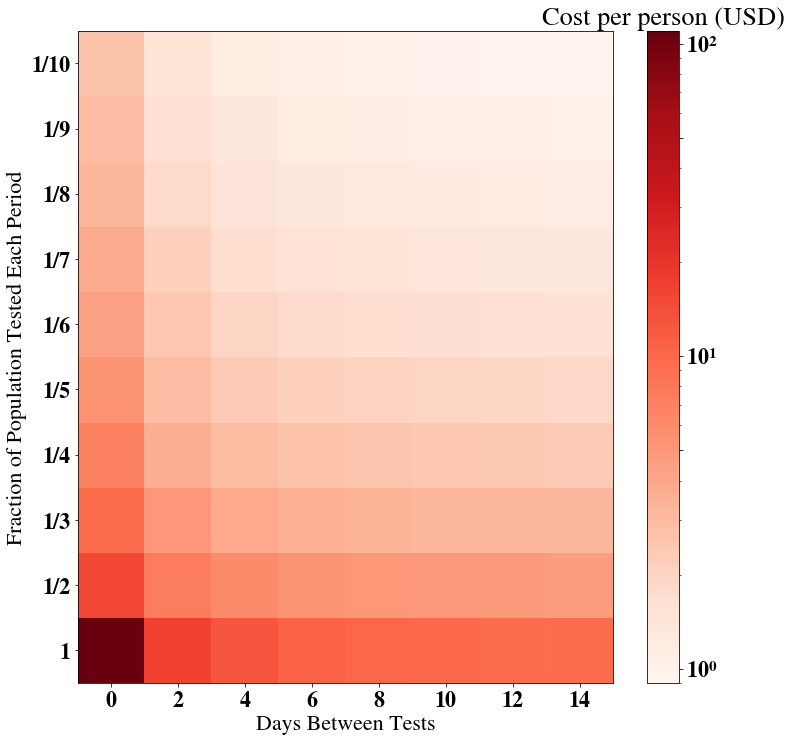

In [81]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_a_i, axis = 2, q = 97.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 0.9, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [1, 5, 10, 50, 100]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-UB-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-UB-India.pdf'))

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


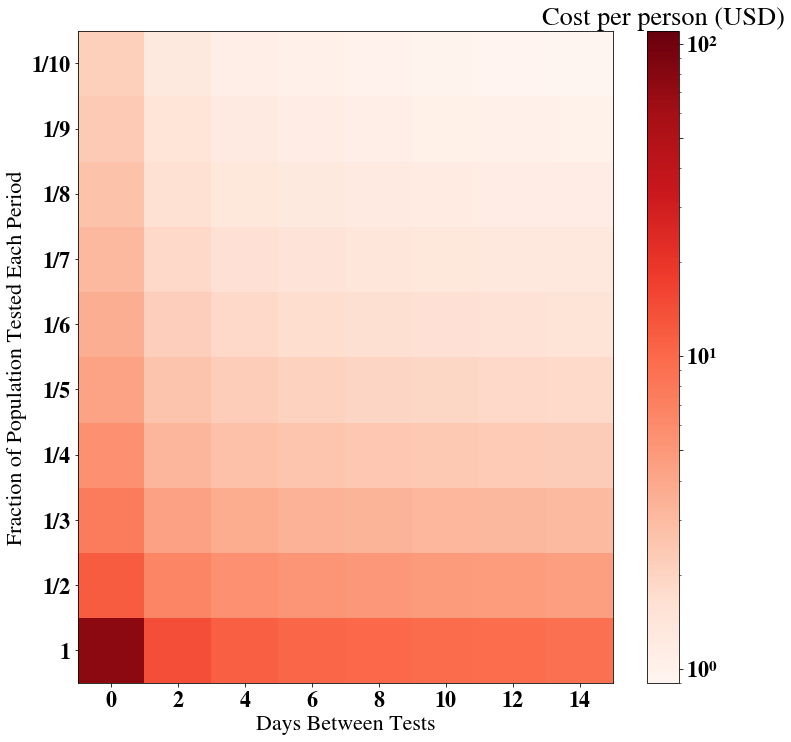

In [82]:
plt.pcolor([1, 3, 5, 7, 9, 11, 13, 15, 17], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           np.percentile(costs_a_i, axis = 2, q = 2.5) / 5000,
           norm = mpl.colors.LogNorm(vmin = 0.9, vmax = 110),
           cmap='Reds')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16], ['0', '2', '4', '6', '8', '10', '12', '14'])

plt.yticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ['1', '1/2', '1/3', '1/4', '1/5', '1/6', '1/7', '1/8',
                                                           '1/9', '1/10'])
#plt.colorbar()
plt.colorbar(ticks = [1, 5, 10, 50, 100]).ax.set_title('Cost per person (USD)')
plt.xlabel('Days Between Tests')
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15])
plt.ylabel('Fraction of Population Tested Each Period');
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-LB-India.png'))
plt.savefig(os.path.join(fig_dir, 'Cost-Antigen-LB-India.pdf'))

In [83]:
yy1 = np.median(total_cases_a_i,
                axis = 2).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))

In [84]:
# frequency
xx1 = np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10)

In [85]:
# number of people
xx2 = 1/np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8)

In [86]:
# , np.ones((80, 1))
xx3 = np.concatenate([(xx1.reshape(80, 1) - np.mean(xx1)) / np.std(xx1),
                      (xx2.reshape(80, 1) - np.mean(xx2)) / np.std(xx2)], axis = 1)

In [87]:
a_i = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

In [88]:
a_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1397.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    8.27e-62
Time:                        13:13:57   Log-Likelihood:                          30.739
No. Observations:                  80   AIC:                                     -57.48
Df Residuals:                      78   BIC:                                     -52.71
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1871      0.019     10.029      0.000       0.150       0.224
x2            -0.9684      0.019    -51.906      0.000      -1.006      -0.931
==============================================================================
Omnibus:                       23.666   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.096
Skew:                           0.460   Prob(JB):                     3.46e-34
Kurtosis:                       9.737   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

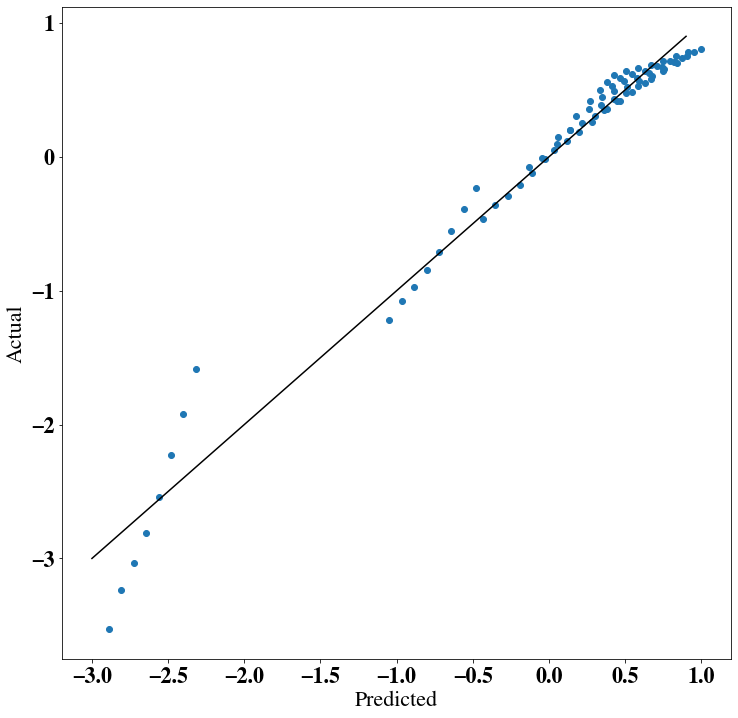

In [89]:
plt.scatter((a_i.predict(xx3)), (yy1 - np.mean(yy1)) / np.std(yy1))
plt.plot(np.arange(-3, 1, 0.1), np.arange(-3, 1, 0.1), c = 'k')
plt.xlabel('Predicted');
plt.ylabel('Actual');

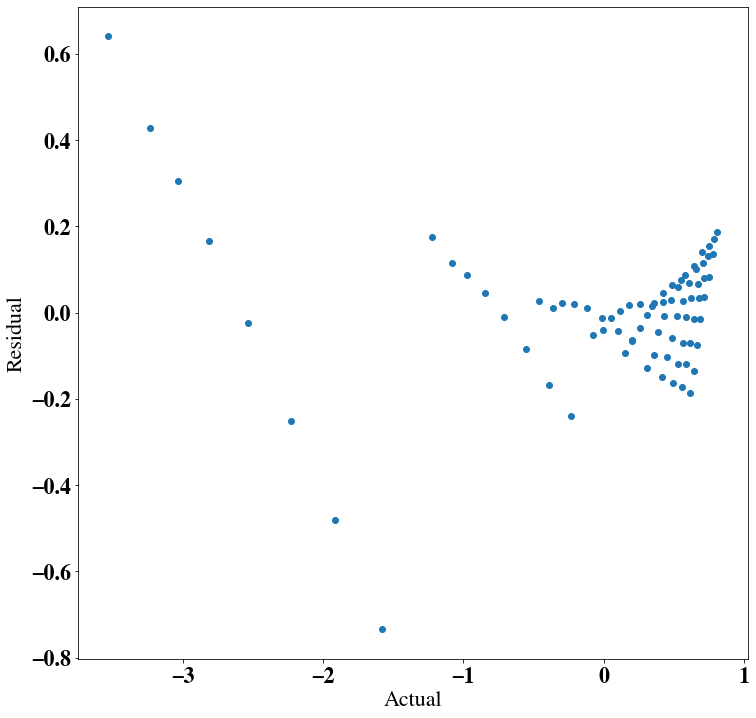

In [90]:
plt.scatter((yy1 - np.mean(yy1)) / np.std(yy1), (a_i.predict(xx3)) - (yy1 - np.mean(yy1)) / np.std(yy1))
plt.ylabel('Residual');
plt.xlabel('Actual');

In [91]:
yy1 = np.concatenate([np.percentile(total_cases_a_i,
                axis = 2, q = 50).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50)),
                     np.percentile(total_cases_r_i,
                axis = 2, q = 50).flatten() * 100 / np.sum(np.percentile(tt1[:, 3, :], axis = 0, q = 50))], axis = 0)

# frequency
xx1 = np.tile(np.array([1, 3, 5, 7, 9, 11, 13, 15]), 10).reshape(80, 1)

xx1 = np.concatenate([xx1, xx1], axis = 0)

# number of people
xx2 = 1/np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 8).reshape(80, 1)

xx2 = np.concatenate([xx2, xx2], axis = 0)

# , np.ones((80, 1))
xx3 = np.concatenate([(xx1 - np.mean(xx1)) / np.std(xx1),
                      (xx2 - np.mean(xx2)) / np.std(xx2),
                      np.array([*np.repeat(0, 80), *np.repeat(1, 80)]).reshape(160, 1)], axis = 1)

i = sm.OLS(((yy1 - np.mean(yy1)) / np.std(yy1)), xx3, hasconst = False).fit()

i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              1204.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                   4.44e-108
Time:                        13:13:58   Log-Likelihood:                          27.212
No. Observations:                 160   AIC:                                     -48.42
Df Residuals:                     157   BIC:                                     -39.20
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1913      0.016     11.744      0.000       0.159       0.223
x2            -0.9578      0.016    -58.794      0.000      -0.990      -0.926
x3             0.0930      0.023      4.035      0.000       0.047       0.138
==============================================================================
Omnibus:                       39.447   Durbin-Watson:                   0.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              610.761
Skew:                           0.019   Prob(JB):                    2.37e-133
Kurtosis:                      12.571   Cond. No.                         1.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
(0.1385 * np.std(yy1))

2.9673570903904842

In [92]:
i.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.958    
Dependent Variable:     y                AIC:                         -48.4242 
Date:                   2020-12-24 13:13 BIC:                         -39.1986 
No. Observations:       160              Log-Likelihood:              27.212   
Df Model:               3                F-statistic:                 1204.    
Df Residuals:           157              Prob (F-statistic):          4.44e-108
R-squared (uncentered): 0.958            Scale:                       0.042464 
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.1913        0.0163       11.7438      0.0000       0.1591       0.2235
x2         -0.9578        0.0163      -58.7938      0.0000      -0.9900      -0.9256
x3          0.0930        0.0230        4.0348      0.0001       0.0475       0.1385
-------------------------------------------------------------------------------
Omnibus:                   39.447           Durbin-Watson:              0.556  
Prob(Omnibus):             0.000            Jarque-Bera (JB):           610.761
Skew:                      0.019            Prob(JB):                   0.000  
Kurtosis:                  12.571           Condition No.:              1      
===============================================================================

"""

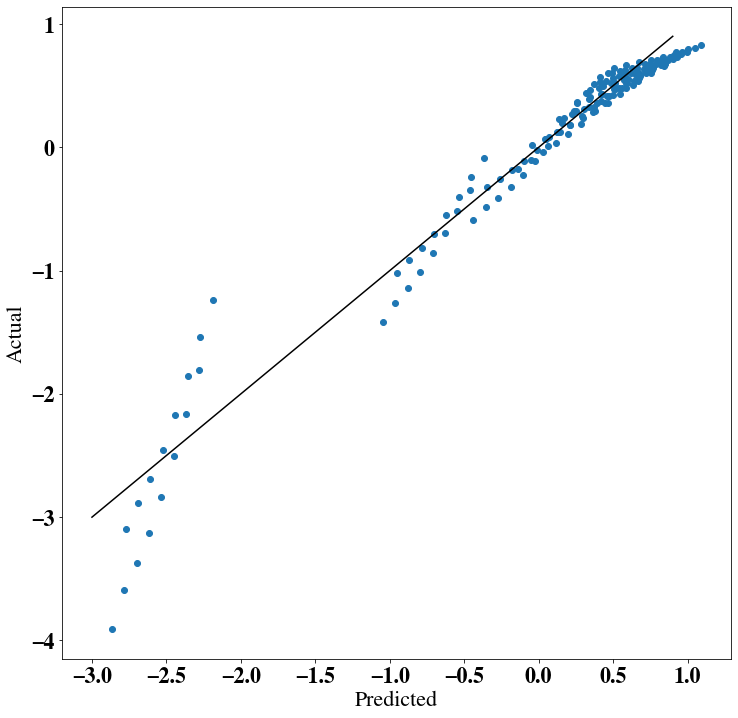

In [93]:
plt.scatter((i.predict(xx3)), (yy1 - np.mean(yy1)) / np.std(yy1))
plt.plot(np.arange(-3, 1, 0.1), np.arange(-3, 1, 0.1), c = 'k')
plt.xlabel('Predicted');
plt.ylabel('Actual');

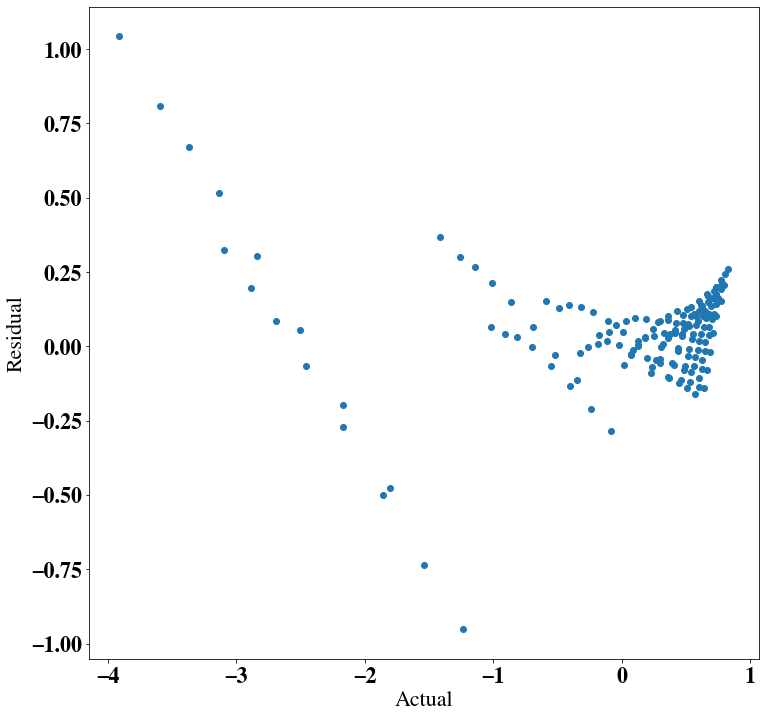

In [94]:
plt.scatter((yy1 - np.mean(yy1)) / np.std(yy1), (i.predict(xx3)) - (yy1 - np.mean(yy1)) / np.std(yy1))
plt.ylabel('Residual');
plt.xlabel('Actual');

In [95]:
r_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1232.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    9.66e-60
Time:                        13:14:00   Log-Likelihood:                          25.856
No. Observations:                  80   AIC:                                     -47.71
Df Residuals:                      78   BIC:                                     -42.95
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2744      0.020     13.838      0.000       0.235       0.314
x2            -0.9455      0.020    -47.678      0.000      -0.985      -0.906
==============================================================================
Omnibus:                       13.275   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.838
Skew:                          -0.725   Prob(JB):                     0.000134
Kurtosis:                       4.802   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
r_u.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.969   
Dependent Variable:     y                AIC:                         -47.7118
Date:                   2020-12-24 13:31 BIC:                         -42.9477
No. Observations:       80               Log-Likelihood:              25.856  
Df Model:               2                F-statistic:                 1232.   
Df Residuals:           78               Prob (F-statistic):          9.66e-60
R-squared (uncentered): 0.969            Scale:                       0.031463
-----------------------------------------------------------------------------------
           Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         0.2744        0.0198       13.8380      0.0000       0.2349       0.3139
x2        -0.9455        0.0198      -47.6782      0.0000      -0.9850      -0.9060
------------------------------------------------------------------------------
Omnibus:                   13.275           Durbin-Watson:              0.999 
Prob(Omnibus):             0.001            Jarque-Bera (JB):           17.838
Skew:                      -0.725           Prob(JB):                   0.000 
Kurtosis:                  4.802            Condition No.:              1     
==============================================================================

"""

In [96]:
a_u.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              807.8
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    7.37e-53
Time:                        13:14:01   Log-Likelihood:                          9.6018
No. Observations:                  80   AIC:                                     -15.20
Df Residuals:                      78   BIC:                                     -10.44
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2402      0.024      9.886      0.000       0.192       0.289
x2            -0.9467      0.024    -38.960      0.000      -0.995      -0.898
==============================================================================
Omnibus:                       64.777   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.359
Skew:                          -2.505   Prob(JB):                     1.03e-80
Kurtosis:                      12.242   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
a_u.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.953   
Dependent Variable:     y                AIC:                         -15.2036
Date:                   2020-12-24 13:31 BIC:                         -10.4396
No. Observations:       80               Log-Likelihood:              9.6018  
Df Model:               2                F-statistic:                 807.8   
Df Residuals:           78               Prob (F-statistic):          7.37e-53
R-squared (uncentered): 0.954            Scale:                       0.047236
-----------------------------------------------------------------------------------
           Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         0.2402        0.0243        9.8859      0.0000       0.1918       0.2886
x2        -0.9467        0.0243      -38.9603      0.0000      -0.9951      -0.8983
------------------------------------------------------------------------------
Omnibus:                  64.777           Durbin-Watson:              1.207  
Prob(Omnibus):            0.000            Jarque-Bera (JB):           368.359
Skew:                     -2.505           Prob(JB):                   0.000  
Kurtosis:                 12.242           Condition No.:              1      
==============================================================================

"""

In [97]:
r_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1149.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    1.36e-58
Time:                        13:14:01   Log-Likelihood:                          23.146
No. Observations:                  80   AIC:                                     -42.29
Df Residuals:                      78   BIC:                                     -37.53
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1999      0.021      9.745      0.000       0.159       0.241
x2            -0.9629      0.021    -46.938      0.000      -1.004      -0.922
==============================================================================
Omnibus:                       25.455   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.737
Skew:                           0.649   Prob(JB):                     4.53e-31
Kurtosis:                       9.343   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
r_i.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.966   
Dependent Variable:     y                AIC:                         -42.2924
Date:                   2020-12-24 13:34 BIC:                         -37.5283
No. Observations:       80               Log-Likelihood:              23.146  
Df Model:               2                F-statistic:                 1149.   
Df Residuals:           78               Prob (F-statistic):          1.36e-58
R-squared (uncentered): 0.967            Scale:                       0.033668
-----------------------------------------------------------------------------------
           Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         0.1999        0.0205        9.7454      0.0000       0.1591       0.2408
x2        -0.9629        0.0205      -46.9381      0.0000      -1.0038      -0.9221
------------------------------------------------------------------------------
Omnibus:                  25.455           Durbin-Watson:              0.771  
Prob(Omnibus):            0.000            Jarque-Bera (JB):           139.737
Skew:                     0.649            Prob(JB):                   0.000  
Kurtosis:                 9.343            Condition No.:              1      
==============================================================================

"""

In [108]:
a_i.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.972   
Dependent Variable:     y                AIC:                         -57.4782
Date:                   2020-12-24 13:35 BIC:                         -52.7142
No. Observations:       80               Log-Likelihood:              30.739  
Df Model:               2                F-statistic:                 1397.   
Df Residuals:           78               Prob (F-statistic):          8.27e-62
R-squared (uncentered): 0.973            Scale:                       0.027847
-----------------------------------------------------------------------------------
           Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-----------------------------------------------------------------------------------
x1         0.1871        0.0187       10.0290      0.0000       0.1500       0.2243
x2        -0.9684        0.0187      -51.9065      0.0000      -1.0056      -0.9313
------------------------------------------------------------------------------
Omnibus:                  23.666           Durbin-Watson:              0.802  
Prob(Omnibus):            0.000            Jarque-Bera (JB):           154.096
Skew:                     0.460            Prob(JB):                   0.000  
Kurtosis:                 9.737            Condition No.:              1      
==============================================================================

"""

In [1122]:
a_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1397.
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    8.27e-62
Time:                        00:05:49   Log-Likelihood:                          30.739
No. Observations:                  80   AIC:                                     -57.48
Df Residuals:                      78   BIC:                                     -52.71
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1871      0.019     10.029      0.000       0.150       0.224
x2            -0.9684      0.019    -51.906      0.000      -1.006      -0.931
==============================================================================
Omnibus:                       23.666   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.096
Skew:                           0.460   Prob(JB):                     3.46e-34
Kurtosis:                       9.737   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1172]:
dd1 = np.percentile(total_cases_r_i / 1994.21, axis = 2, q = 50).flatten() - np.percentile(total_cases_a_i / 1994.21, axis = 2, q = 50).flatten()

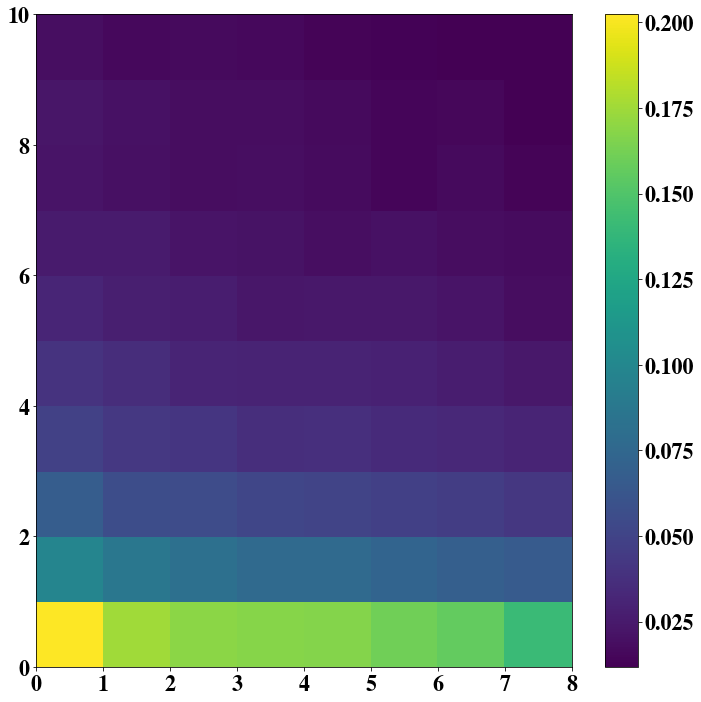

In [1171]:
plt.pcolor(np.percentile(total_cases_r_i / 1994.21, axis = 2, q = 50) - np.percentile(total_cases_a_i / 1994.21, axis = 2, q = 50))
plt.colorbar()

In [1173]:
np.median(dd1)

0.027637510593167325

In [1174]:
np.percentile(dd1, q = 2.5)

0.011922515682902078

In [1175]:
np.percentile(dd1, q = 97.5)

0.16955837148545028